# ***COMPARISON BETWEEN SPARSE RETRIEVAL MODELS***

### Davide Baldelli, Alma Mater Studiorum - University of Bologna
### davide.badelli4@studio.unibo.it

In this notebook we are going to present several *bag-of-words* information retrieval models and test them on the *WikiIR1k* [[1](#ref)] dataset, and on two datasets taken from the *BEIR* benchmark [[10](#ref)]:  *FiQA-2018* , and *Touché-2020*. 

Several bag-of-words models have been developed for the task of information retrieval (IR). It consists in, given a set of documents and a query (a set of terms), find the most relevant documents for that query. Bag-of-words models make a simple but helpful assumption: the more a document contains a term, the more likely it is to be *about*  that term.

It is necessary to clarify the terminology and give some definitions: 
* $d$ - a document
* $q$ - a query
* $t$ - a term
* $N$ - size of the corpus of documents
* $df_t$ - document frequency of the term $t$, i.e. the number of documents in wich the term $t$ appears
* $tf_{td}$ - term-frequency between the term $t$ and the document $d$, i.e. the number of occurrencies of the term $t$ in the document $d$.
* $L_d$ - Length of the document $d$
* $L_{avg}$ - average length of the documents in the corpus

***

The different ranking functions that we are going to evaluate is listed in the following table:

|MODEL NAME | FORMULA| 
|--- | --- |
$$TFIDF$$ |  $$\sum_{t\in q} \log_{10}(N/df_t) \cdot \log(1 + tf_{td})$$
$BM25 \ Okapi$ | $$\sum_{t\in q} \log\left( \frac{N - df_t + 0.5}{df_t + 0.5} \right) \cdot \frac{tf_{td}} {tf_{td} + k_1 \cdot (1-b+b\cdot \frac{L_d}{L_{avg}})}$$
$$BM25 \ Lucene$$ | $$\sum_{t\in q} \log \left ( \frac{N - df_t + 0.5}{df_t + 0.5} +1 \right ) \cdot \frac{tf_{td}} {tf_{td} + k_1 \cdot (1-b+b\cdot \frac{L_d}{L_{avg}})}$$
$$BM25 \ ATIRE$$ | $$\sum_{t\in q} \log \left ( \frac{N}{df_t} \right ) \cdot \frac{tf_{td} \cdot (1+k_1)} {tf_{td} + k_1 \cdot (1-b+b\cdot \frac{L_d}{L_{avg}})}$$
$$BM25L$$| $$\sum_{t\in q} \log \left ( \frac{N+1}{df_t+0.5}\right ) \cdot \frac{(k_1 +1)\cdot (c_{td}+\delta)} {k_1 + c_{td} + \delta}$$
$$BM25+$$ | $$\sum_{t\in q} \log \left ( \frac{N+1}{df_t}\right ) \cdot \left( \frac{(k_1 +1)\cdot tf_{td}} {k_1 \cdot (1-b+b \cdot \frac{L_d}{L_{avg}}) + tf_{td}} + \delta \right )$$
$$BM25\ Adtp$$ | $$\sum_{t\in q} G_q^1 \cdot \frac{(k_1^* +1) \cdot tf_{td}}{k_1^* \cdot (1-b+b\cdot(\frac{L_d}{L_{avg}})) + tf_{td}}$$
$$TF_{l\circ\delta\circ p}\times IDF$$ | $$\sum_{t\in q} \log \left ( \frac{N+1}{df_t}\right ) \cdot  \left( 1+\log\left(1+\log\left(\frac{tf_{td}}{1-b+b\cdot \frac{L_d}{L_{avg}}} + \delta\right)\right)\right )$$

The implementation is an extension and adaptation of the [rank-bm25](https://github.com/dorianbrown/rank_bm25) library.

The library comes with the implementations of $Okapi \ BM25$, $BM25L$, and $BM25+$. We have slightly improved them and added the ones in the table above. Furthermore we have implemented a wrapper `Retriever` class able to retrieve with any of the techniques previously listed.





## Install dependencies

In [ ]:
!pip install --quiet nltk
!pip install --quiet datasets

## Utils

The following is a flag to set if the tokenized datasets are to be found in the Drive or not

In [ ]:
on_drive = False # True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import psutil
import pandas as pd
def get_ram_info():
    infos = []
    columns = ["Total (Gb)", "Available (Gb)", "Available (%)", "Used (Gb)"]
    ram = psutil.virtual_memory()
    infos.append(round(ram[0] / 10**9, 2))
    infos.append(round(ram[1] / 10**9, 2))
    infos.append(round(ram[2], 2))
    infos.append(round(ram[3] / 10**9, 2))
    display(pd.DataFrame([infos], columns=columns , index = ["Ram"]))

In [ ]:
get_ram_info()

,Total (Gb),Available (Gb),Available (%),Used (Gb)
Ram,13.62,12.06,11.4,1.26


## Tokenizer function

We are going to perform a couple of simple preprocessing steps on docs and queries, exploiting the *nltk* library:

1. Punctuation removal 
2. Lowercase words
3. Stopword removal
4. Stemming with Porter stemmer

In [ ]:
import nltk
from nltk import PorterStemmer
from nltk.corpus import stopwords
import string  

# Downloading and importing English stopwords
nltk.download("stopwords")
stop_words = stopwords.words("english")

# As we first remove punnctuation, 
# to remove it even from stopwords
stop_words = [sw.translate(str.maketrans("", "", string.punctuation)) for sw in stop_words]

# Initializing porter stemmer
ps = PorterStemmer()

def tokenizer(doc):
  # remove punctuation
  processed_doc = doc.translate(str.maketrans("", "", string.punctuation))

  # lowercase and tokenize the doc
  processed_doc = processed_doc.lower().split()
  
  # removing stopwords
  processed_doc = [w for w in processed_doc if not w in stop_words]

  # applying porter stemmer
  processed_doc = [ps.stem(w) for w in processed_doc]

  return processed_doc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's see how it works with a simple example

In [ ]:
s = "!hi. Wh?at is the weat[h]er lik?Ely to be??"
print(f"INPUT STRING:      {s}\n")
s = s.translate(str.maketrans("", "", string.punctuation))
print(f"STEP 1:            {s}")
s = s.lower().split()
print(f"STEP 2:            {s}")
s = [w for w in s if not w in stop_words]
print(f"STEP 3:            {s}")
s = [ps.stem(w) for w in s]
print(f"STEP 4:            {s}")

s = "!hi. Wh?at is the weat[h]er lik?Ely to be??"
print(f"\nTOKENIZED STRING:  {tokenizer(s)}")

INPUT STRING:      !hi. Wh?at is the weat[h]er lik?Ely to be??

STEP 1:            hi What is the weather likEly to be
STEP 2:            ['hi', 'what', 'is', 'the', 'weather', 'likely', 'to', 'be']
STEP 3:            ['hi', 'weather', 'likely']
STEP 4:            ['hi', 'weather', 'like']

TOKENIZED STRING:  ['hi', 'weather', 'like']


## WIkiIR

WikiIR is a python tool for building large scale Wikipedia-based Infromation Retrieval datasets [[1](#ref)]. 

Frej et al. propose to construct an IR dataset as follows: 
* **Wikipedia dump extraction.** Extract plain text from an English *Wikipedia* dump using *WikiExtractor* ([github](https://github.com/attardi/wikiextractor)). It produces a *json* file that contains the URL, title and text. 
* **Document extraction.** The set of documents is extracted using the *text* field associated with the *json* file produced by the previous step. The first line of the text field (that is the article title) is deleted to avoid the task to be excessively easy. 
* **Query construction.** The queries are the titles of the articles. 
* **Relevance label construction.** They assign a relevance label of two for query-document pairs that come from the same article, and a relevance label equal to one to a query-document pair if there is a link from the first sentence of the article of the document that points to the article of the query.

We are not going to evaluate the models on the different labels, but only on *relevant* documents, that is to say any document with a label greater or equal than 1.

We are going to use the smallest version of the WikIR dataset, due to our computational limitations. 

### Download and import data

Let's download the data

In [ ]:
# importing necessary modules
import requests, zipfile
from io import BytesIO
print('Downloading started')

#Defining the zip file URL
url = 'https://zenodo.org/record/3565761/files/wikIR1k.zip?download=1'

# Split URL to get the file name
# filename = url.split('/')[-1]

# Downloading the file by sending the request to the URL
req = requests.get(url)
print('Downloading Completed')

# extracting the zip file contents
zipfile= zipfile.ZipFile(BytesIO(req.content))
zipfile.extractall('./data')

Let's import the documents 

In [ ]:
import pandas as pd

docs = pd.read_csv("data/wikIR1k/documents.csv")
docs.head()

,id_right,text_right
0,1781133,it was used in landing craft during world war ...
1,2426736,after rejecting an offer from cambridge univer...
2,2224122,mat zan coached kuala lumpur fa in 1999 and wo...
3,219642,a barcode is a machine readable optical label ...
4,1728654,since the subordination of the monarchy under ...


Let's import the queries

In [ ]:
import pandas as pd

train_queries = pd.read_csv("data/wikIR1k/training/queries.csv")
val_queries = pd.read_csv("data/wikIR1k/validation/queries.csv")
test_queries = pd.read_csv("data/wikIR1k/test/queries.csv")

Let's import the dataset with the relevant documents

In [ ]:
with open("data/wikIR1k/training/qrels") as f:
  lines = f.readlines()

lines = [line.replace("\n", "").split("\t") for line in lines]
lines = [[int(n) for n in l] for l in lines]
columns = ["id_left", "zeros", "id_right", "label"]
train_qrels = pd.DataFrame(lines, columns = columns) 
train_qrels = train_qrels.drop(columns = ["zeros"])

with open("data/wikIR1k/validation/qrels") as f:
  lines = f.readlines()

lines = [line.replace("\n", "").split("\t") for line in lines]
lines = [[int(n) for n in l] for l in lines]
columns = ["id_left", "zeros", "id_right", "label"]
val_qrels = pd.DataFrame(lines, columns = columns) 
val_qrels = val_qrels.drop(columns = ["zeros"])

with open("data/wikIR1k/test/qrels") as f:
  lines = f.readlines()

lines = [line.replace("\n", "").split("\t") for line in lines]
lines = [[int(n) for n in l] for l in lines]  ## [list(map(int, line)) for line in lines]
columns = ["id_left", "zeros", "id_right", "label"]
test_qrels = pd.DataFrame(lines, columns = columns) 
test_qrels = test_qrels.drop(columns = ["zeros"])

The data comes with train, validation and test split, and for each split we have a dataset containing the queries and a dataset containing the relevant documents for each query. Separately we have a dataset containing the documents. As we don't have to train models, we are going to merge the different splits. 


In [ ]:
queries = train_queries.append(val_queries).append(test_queries)
qrels = train_qrels.append(val_qrels).append(test_qrels)

### Explore dataset

#### Documents

Firts, let's dive into the documents' dataset. 

In [ ]:
display(docs.head())
print(f"\n\nNumber of documents: {len(docs)}")

,id_right,text_right
0,1781133,it was used in landing craft during world war ...
1,2426736,after rejecting an offer from cambridge univer...
2,2224122,mat zan coached kuala lumpur fa in 1999 and wo...
3,219642,a barcode is a machine readable optical label ...
4,1728654,since the subordination of the monarchy under ...




Number of documents: 369721


Let's see how a sample looks like

In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(docs))

doc_text = docs.iloc[idx]["text_right"] 
doc_id = docs.iloc[idx]["id_right"]

print(f"DOC ID: {doc_id}\n\n")
print(f"DOC TEXT: ")
pprint(doc_text)

DOC ID: 137763


DOC TEXT: 
('after his departure from yes bruford spent the rest of the 1970s playing in '
 'king crimson touring with genesis and u k and eventually forming his own '
 'group bruford in the 1980s bruford returned to king crimson for three years '
 'collaborated with several artists including the roches patrick moraz and '
 'david torn and formed his jazz band earthworks in 1986 he then played in '
 'anderson bruford wakeman howe which eventually led to his second stint in '
 'yes bruford played in king crimson for his third and final tenure between '
 '1994 and 1997 after which he continued with earthworks and further '
 'collaborations on 1 january 2009 bruford retired from public performance '
 'barring one private gig in 2011 he released his autobiography and continues '
 'to speak and write about music he operates his record labels summerfold and '
 'winterfold records in 2016 after four and a half years of study bruford '
 'earned a phd in music at the university

In this version of WikIR, the documents are truncated at 200 tokens. 

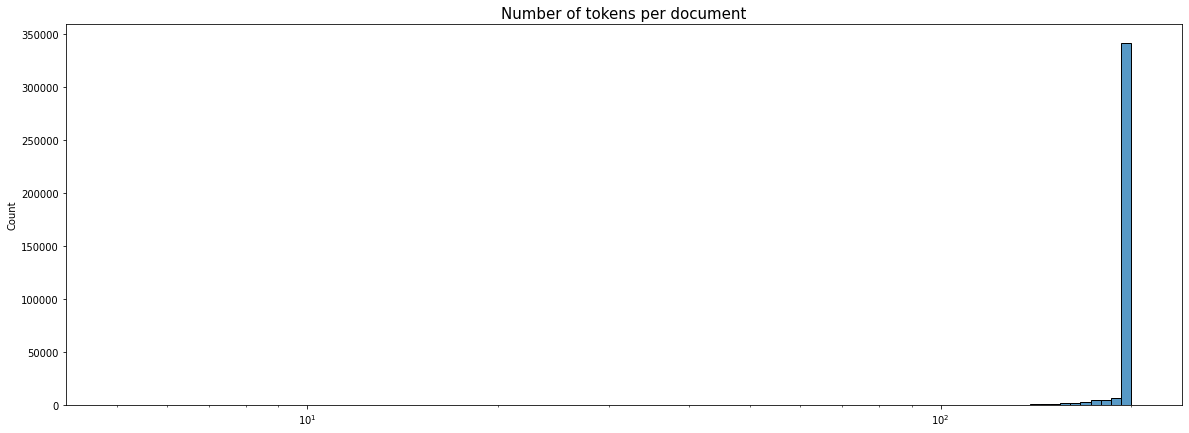

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

lens = [len(text.split()) for text in docs["text_right"]]

plt.figure(figsize=(20,7))
sns.histplot(x = lens, bins = 100, log_scale = True)
plt.title("Number of tokens per document", size = 15)
plt.show()

In [ ]:
print(f"Minimum length of documents: {np.min(lens)}")
print(f"Average length of documents: {np.mean(lens)}")
print(f"Maximum length of documents: {np.max(lens)}")
print(f"Percentage of documents with 200 tokens: {round(np.mean([x == 200 for x in lens]) * 100, 2)} %")

Minimum length of documents: 5
Average length of documents: 197.69969517555128
Maximum length of documents: 200
Percentage of documents with 200 tokens: 90.69 %


#### Queries

Let's dive into queries

In [ ]:
display(queries.head())
print(f"\n\nNumber of queries: {len(queries)}")

,id_left,text_left
0,123839,yanni
1,188629,k pop
2,13898,venice film festival
3,316959,downtown brooklyn
4,515031,pennsylvania house of representatives




Number of queries: 1644


Let's see how a sample looks like

In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(queries))

query_text = queries.iloc[idx]["text_left"] 
query_id = queries.iloc[idx]["id_left"]

print(f"QUERY ID: {query_id}\n")
print(f"QUERY TEXT: {query_text}")

QUERY ID: 12823

QUERY TEXT: togo


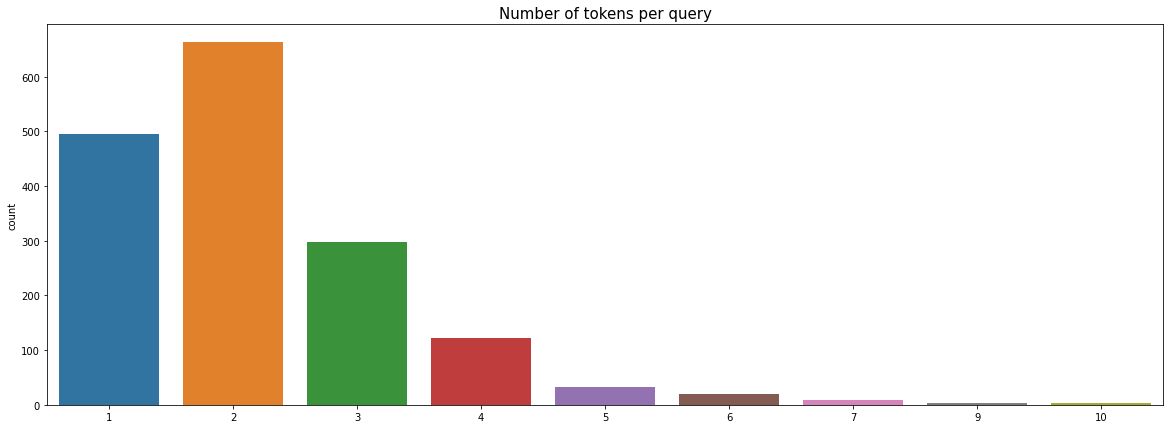

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

lens = [len(text.split()) for text in queries["text_left"]]

plt.figure(figsize=(20,7))
sns.countplot(x = lens)
plt.title("Number of tokens per query", size = 15)
plt.show()

In [ ]:
print(f"Average length of queries: {np.mean(lens)}")

Average length of queries: 2.1849148418491486


#### Query relevance

Let's dive into the relevance label's dataset

In [ ]:
display(qrels.head())
print(f"\n\nNumber of labels: {len(qrels)}")

,id_left,id_right,label
0,123839,123839,2
1,123839,1793430,1
2,123839,806300,1
3,123839,806075,1
4,123839,836567,1




Number of labels: 57113


In [ ]:
print(f"Number of different queries: {qrels.id_left.nunique()}")
print(f"Number of different docs: {qrels.id_right.nunique()}")


Number of different queries: 1644
Number of different docs: 51666


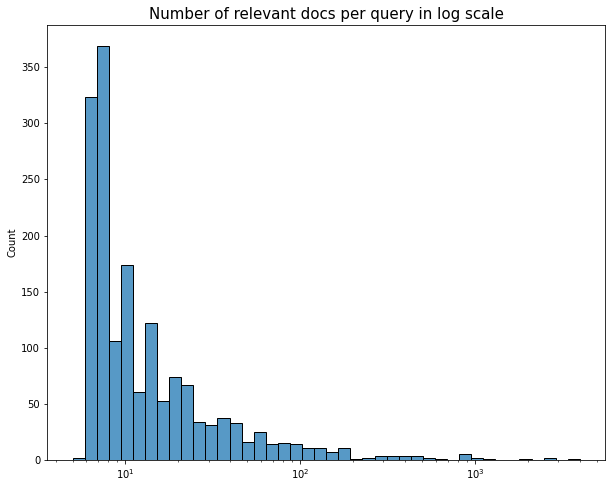

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

query_ids = qrels.id_left.unique()

# Number of relevant documents per query
n_rels = [len(qrels[qrels["id_left"] == query_id]) for query_id in query_ids]

plt.figure(figsize = (10, 8))
sns.histplot(n_rels, log_scale = True)
plt.title("Number of relevant docs per query in log scale", size = 15)
plt.show()

In [ ]:
idx = query_ids[np.argmax(n_rels)]

print(f"Average number of relevant documents per query: {np.mean(n_rels)}")
print()
print(f"The query with more relevants docs is: {queries[queries['id_left'] == idx]['text_left'].item()}")
print(f"It has {np.max(n_rels)} relevant documents")
print(f"95% of documents have less than {round(np.percentile(n_rels, 95))} relevants documents")

Average number of relevant documents per query: 34.740267639902676

The query with more relevants docs is: association football
It has 3982 relevant documents
95% of documents have less than 91 relevants documents


In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(qrels))

doc_id = qrels.iloc[idx]["id_right"] 
query_id = qrels.iloc[idx]["id_left"]
label = qrels.iloc[idx]["label"]

doc_text = docs[docs["id_right"] == doc_id]["text_right"].item()
query_text = queries[queries["id_left"] == query_id]["text_left"].item()

print(f"QUERY TEXT: {query_text}\n\n")
print(f"DOC TEXT:")
pprint(doc_text)
print(f"\n\nLABEL: {label}")

QUERY TEXT: zaragoza


DOC TEXT:
('the kinsmen joined aysun s brother when matruh al arabi rebelled and entered '
 'zaragoza in muslim year 175 ad 791 2 amrus turned on his master and he and '
 'sarhabil ibn saltan al zawagi attacked matruh with swords killing him amrus '
 'then went to c rdoba where he was rewarded by being named wali of talavera '
 'in 802 he was sent from toledo as general against another zaragoza rebel '
 'taking zaragoza and huesca expelling bahlul ibn marzuq and fortifying a '
 'settlement that would become tudela installing there his son yusuf ibn amrus '
 'zaragoza again rebelled in december 802 this time under fortun ibn musa '
 'apparently a member of the banu qasi and amrus was in the year 803 804 '
 'appointed as governor of zaragoza he installed his kinsman sabrit in huesca '
 'in 807 he quelled a rebellion in tudela and upon the death of oriol of '
 'aragon he occupied the county of sobrarbe which was only regained by aragon '
 'under aznar gal ndez i in 

### Preprocessing

We are going to tokenize each document. As this operation takes approximately 20 mins, I have saved them to my Google Drive, so to import the already preprocessed documents without wasting time. 

In [ ]:
#docs["cleaned_text"] = docs["text_right"].map(tokenizer)
#docs.to_csv("gdrive/MyDrive/tokenized_documents.csv")

In [ ]:
import pandas as pd

if on_drive:
  docs = pd.read_csv("gdrive/MyDrive/tokenized_documents.csv", index_col = 0)
  docs["cleaned_text"] = docs["cleaned_text"].map(lambda x: x.replace("'", "").replace("[", "").replace("]", "").split(", "))
else: 
  docs["cleaned_text"] = docs["text_right"].map(tokenizer)
docs.sample(5)

,id_right,text_right,cleaned_text
21957,1969612,he is best known as the author of welded steel...,"[best, known, author, weld, steel, reinforc, c..."
3401,2367931,located approximately west of sydney the garde...,"[locat, approxim, west, sydney, garden, one, w..."
100072,605967,for example 50 percent confluence means roughl...,"[exampl, 50, percent, confluenc, mean, roughli..."
234204,559342,in the front and rear projection television ma...,"[front, rear, project, televis, market, compet..."
231200,2191589,it stars johnny simmons amy landecker jason sc...,"[star, johnni, simmon, ami, landeck, jason, sc..."


Let's see how a tokenized document looks like

In [ ]:
idx = np.random.randint(len(docs))

print("DOCUMENT: ")
pprint(docs.iloc[idx]["text_right"])
print("\n\nTOKENIZED DOCUMENT: ")
print(docs.iloc[idx]["cleaned_text"])

DOCUMENT: 
('the battle took place in the bay of biscay between two light cruisers of the '
 'british royal navy and a destroyer and a torpedo boat flotilla of the german '
 'kriegsmarine hoping to intercept and escort a blockade runner the battle was '
 'fought as part of the allied operation stonewall which was to intercept '
 'german blockade runners off the west coast of france in the confused action '
 'that followed the two british cruisers hms enterprise and hms glasgow '
 'respectively sank t26 together with her sister ship t25 and the destroyer '
 'z27 in late december 1943 a german kriegsmarine destroyer flotilla '
 'reinforced by six large elbing class torpedo boats was ordered to the bay of '
 'biscay in order to escort into a french port the blockade runners osorno and '
 'alsterufer which were carrying vital cargo from japan the germans codenamed '
 'this operation bernau the blockade runner osorno reached the gironde on 26 '
 'december but struck a wreck in the estuary a

Save docs, queries and qrels in specific variables

In [ ]:
w_docs = docs
w_queries = queries
w_qrels = qrels

##BEIR FiQA-2018

BEIR [[10](#ref)] is benchmark for the evaluation of Information Retrieval Models. We will use two of its dataset for the evaluation fo our models. 

The first is **FiQA - 2018** (Financial Opinion Mining and Question Answering) [link](https://sites.google.com/view/fiqa/). 

It is a dataset for Information Retrieval and Question Answering in the financial domain.

#### Download and import data

In [ ]:
from datasets import load_dataset

fiqa_corpus = load_dataset("BeIR/fiqa", "corpus")
fiqa_queries = load_dataset("BeIR/fiqa", "queries")
fiqa_qrels = load_dataset("BeIR/fiqa-qrels")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
fiqa_corpus

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 57638
    })
})

In [ ]:
docs = pd.DataFrame(fiqa_corpus["corpus"]).drop(columns = ["title"])
docs["_id"] = docs["_id"].map(int)
docs.sample(5)

,_id,text
3100,32177,If you can borrow for an asset that gives you ...
13423,138071,Approach property management companies. I work...
22778,235972,"""You have several options depending on your to..."
9338,96121,"""If you mean, If I invest, say, $1000 in a sto..."
26164,270811,Find out why it's doing the way it is before g...


In [ ]:
fiqa_queries

DatasetDict({
    queries: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 6648
    })
})

In [ ]:
import pandas as pd

queries = pd.DataFrame(fiqa_queries["queries"]).drop(columns = ["title"])
queries["_id"] = queries["_id"].map(int)
queries.sample(5)

,_id,text
4410,7956,Some stock's prices don't fluctuate widely - I...
3898,7139,How can I verify that a broker I found online ...
4993,9667,Can you beat the market by investing in double...
5040,9797,Historical Stock Price Quote on delisted stock...
2246,4170,Is there a financial product that allows specu...


In [ ]:
fiqa_qrels

DatasetDict({
    train: Dataset({
        features: ['query-id', 'corpus-id', 'score'],
        num_rows: 14166
    })
    test: Dataset({
        features: ['query-id', 'corpus-id', 'score'],
        num_rows: 1706
    })
    validation: Dataset({
        features: ['query-id', 'corpus-id', 'score'],
        num_rows: 1238
    })
})

As we don't need to train models, we will use the three splits for evaluation.

In [ ]:
train_qrels = pd.DataFrame(fiqa_qrels["train"])
val_qrels = pd.DataFrame(fiqa_qrels["validation"])
test_qrels = pd.DataFrame(fiqa_qrels["test"])
qrels = train_qrels.append(val_qrels).append(test_qrels)

qrels.sample(5)

,query-id,corpus-id,score
12060,8498,235772,1
12994,9675,128021,1
2313,2148,561920,1
1763,1717,561750,1
4775,3409,92072,1


### Explore dataset

#### Documents

Firts, let's dive into the documents' dataset. 

In [ ]:
display(docs.head())
print(f"\n\nNumber of documents: {len(docs)}")

,_id,text
0,3,I'm not saying I don't like the idea of on-the...
1,31,So nothing preventing false ratings besides ad...
2,56,You can never use a health FSA for individual ...
3,59,Samsung created the LCD and other flat screen ...
4,63,Here are the SEC requirements: The federal sec...




Number of documents: 57638


Let's see how a sample looks like

In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(docs))

doc_text = docs.iloc[idx]["text"] 
doc_id = docs.iloc[idx]["_id"]

print(f"DOC ID: {doc_id}\n\n")
print(f"DOC TEXT: ")
pprint(doc_text)

DOC ID: 53431


DOC TEXT: 
('I would suggest that oil stocks are going down due to reduced earnings '
 'predictions.  The market may go too far in selling off oil and oil-related '
 'stocks.  You may be able to pick up a bargain, but beware that prices may '
 'continue to fall in the short to medium term.')


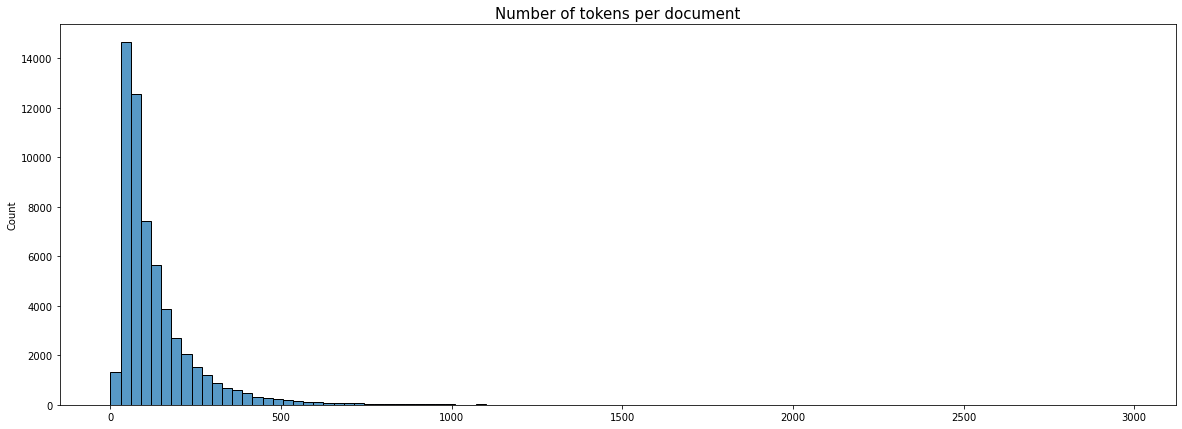

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

lens = [len(text.split()) for text in docs["text"]]

plt.figure(figsize=(20,7))
sns.histplot(x = lens, bins = 100)
plt.title("Number of tokens per document", size = 15)
plt.show()

In [ ]:
print(f"There are {np.sum(np.array(lens) == 0)} empty documents ")

There are 38 empty documents 


In [ ]:
print(f"Minimum length of documents: {np.min(lens)}")
print(f"Average length of documents: {np.mean(lens)}")
print(f"Maximum length of documents: {np.max(lens)}")

Minimum length of documents: 0
Average length of documents: 132.90447274367605
Maximum length of documents: 2973


#### Queries

Let's dive into queries

In [ ]:
display(queries.head())
print(f"\n\nNumber of queries: {len(queries)}")

,_id,text
0,0,What is considered a business expense on a bus...
1,4,Business Expense - Car Insurance Deductible Fo...
2,5,Starting a new online business
3,6,“Business day” and “due date” for bills
4,7,New business owner - How do taxes work for the...




Number of queries: 6648


Let's see how a sample looks like

In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(queries))

query_text = queries.iloc[idx]["text"] 
query_id = queries.iloc[idx]["_id"]

print(f"QUERY ID: {query_id}\n")
print(f"QUERY TEXT: {query_text}")

QUERY ID: 1474

QUERY TEXT: A merchant requests that checks be made out to “Cash”. Should I be suspicious?


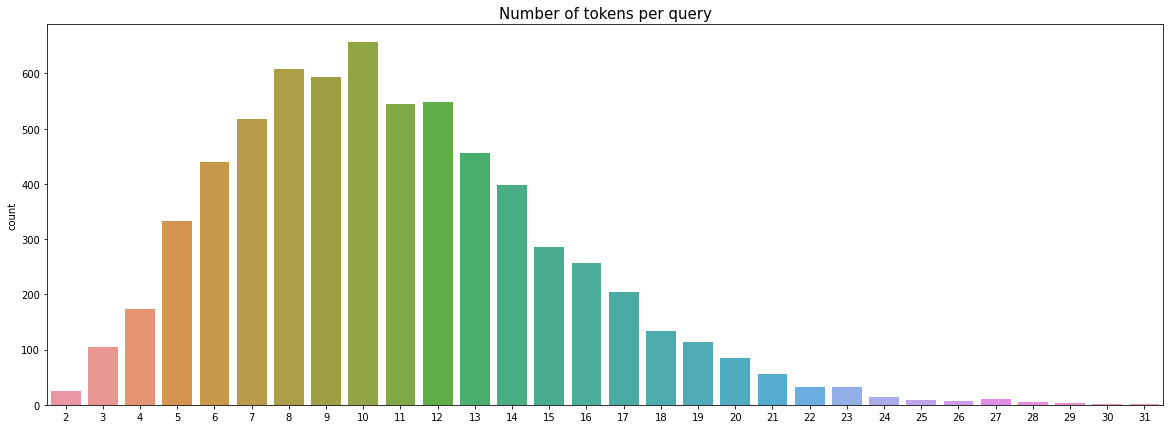

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

lens = [len(text.split()) for text in queries["text"]]

plt.figure(figsize=(20,7))
sns.countplot(x = lens)
plt.title("Number of tokens per query", size = 15)
plt.show()

In [ ]:
print(f"Average length of queries: {np.mean(lens)}")

Average length of queries: 10.82205174488568


#### Query relevance

Let's dive into the relevance label's dataset

In [ ]:
display(qrels.head())
print(f"\n\nNumber of labels: {len(qrels)}")

,query-id,corpus-id,score
0,0,18850,1
1,4,196463,1
2,5,69306,1
3,6,560251,1
4,6,188530,1




Number of labels: 17110


In [ ]:
print(f"Number of different queries: {qrels['query-id'].nunique()}")
print(f"Number of different docs: {qrels['corpus-id'].nunique()}")

Number of different queries: 6648
Number of different docs: 17110


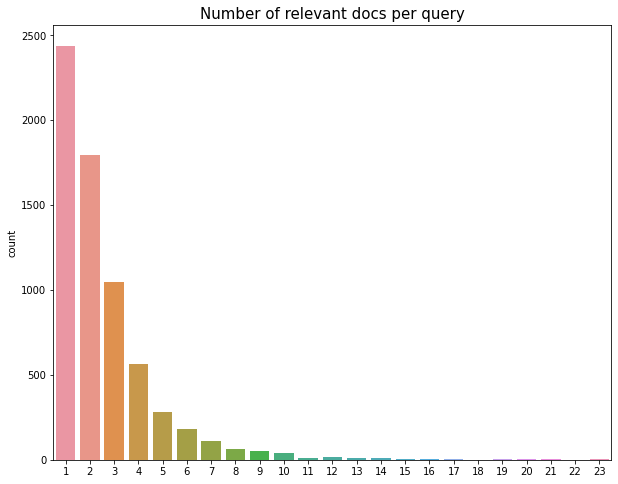

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

query_ids = qrels["query-id"].unique()

# Number of relevant documents per query
n_rels = [len(qrels[qrels["query-id"] == query_id]) for query_id in query_ids]

plt.figure(figsize = (10, 8))
sns.countplot(x = n_rels)
plt.title("Number of relevant docs per query", size = 15)
plt.show()

In [ ]:
idx = query_ids[np.argmax(n_rels)]

print(f"Average number of relevant documents per query: {np.mean(n_rels)}")
print()
print(f"The query with more relevants docs is: {queries[queries['_id'] == idx]['text'].item()}")
print(f"It has {np.max(n_rels)} relevant documents")
print(f"95% of documents have less than {round(np.percentile(n_rels, 95))} relevants documents")

Average number of relevant documents per query: 2.5737063778580023

The query with more relevants docs is: What options do I have at 26 years old, with 1.2 million USD?
It has 23 relevant documents
95% of documents have less than 7 relevants documents


In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(qrels))

doc_id = qrels.iloc[idx]["corpus-id"] 
query_id = qrels.iloc[idx]["query-id"]
label = qrels.iloc[idx]["score"]

doc_text = docs[docs["_id"] == doc_id]["text"].item()
query_text = queries[queries["_id"] == query_id]["text"].item()

print(f"QUERY TEXT: {query_text}\n\n")
print(f"DOC TEXT:")
pprint(doc_text)
print(f"\n\nLABEL: {label}")

QUERY TEXT: Is there any way to know how much new money the US is printing?


DOC TEXT:
('"The Federal Reserve is not the only way that money can be ""printed."" '
 'Every bank does fractional reserve banking, thereby increasing the money '
 "supply every time they make a new loan. There's a number called the reserve "
 'requirement which limits how much money each bank can create. Lowering the '
 'reserve requirement allows banks to create more money. Raising it will '
 'destroy money. But banks can also destroy money by calling in loans or being '
 'less willing to make new loans.  So when you look at the number of banks in '
 "the US, and the number of loans they all have, it's impossible to figure out "
 'exactly how much the money supply is expanding or contracting."')


LABEL: 1


### Preprocessing

We are going to tokenize each document. As this operation takes approximately 2 mins, I have saved them to my Google Drive, so to import the already preprocessed documents without wasting time. 

In [ ]:
# %time docs["cleaned_text"] = docs["text"].map(tokenizer)
# docs.to_csv("gdrive/MyDrive/fiqa_tokenized_documents.csv")

CPU times: user 2min 20s, sys: 916 ms, total: 2min 21s
Wall time: 2min 39s


In [ ]:
import pandas as pd

if on_drive:
  docs = pd.read_csv("gdrive/MyDrive/fiqa_tokenized_documents.csv", index_col = 0)
  docs["cleaned_text"] = docs["cleaned_text"].map(lambda x: x.replace("'", "").replace("[", "").replace("]", "").split(", "))
else: 
  docs["cleaned_text"] = docs["text"].map(tokenizer)
  
docs.sample(5)

,_id,text,cleaned_text
15020,154741,"I've done this, though with a loan company rat...","[ive, done, though, loan, compani, rather, ban..."
45270,471259,"""Hahaha, that sounds good but in real life pen...","[hahaha, sound, good, real, life, pension, alm..."
44417,462255,"I'm not business-savvy, but that seems like a ...","[im, businesssavvi, seem, like, good, idea, wi..."
5139,53610,"""I love this part: &gt;...and that theft is b...","[love, part, gtand, theft, combin, consum, fra..."
57541,598997,"None whatsoever, no. Moreover, trying somethin...","[none, whatsoev, moreov, tri, someth, like, wo..."


Let's see how a tokenized document looks like

In [ ]:
import numpy as np
from pprint import pprint

idx = np.random.randint(len(docs))

print("DOCUMENT: ")
pprint(docs.iloc[idx]["text"])
print("\n\nTOKENIZED DOCUMENT: ")
print(docs.iloc[idx]["cleaned_text"])

DOCUMENT: 
("That was my thought.  Looking at it, I'm thinking he's really got two big "
 "expenses that he's seeking the money for: New equipment/space to expand "
 'production capability with, and advertising funds to get his name out '
 'there.  He walked in and owned the room. He put his product in front of '
 'people, displayed to the sharks that customization was the name of the game, '
 'and was all over exactly that core idea with examples right out of the gate. '
 'Yeah, he was doing a pretty good job reaching his immediate investor '
 "audience, but let's be perfectly frank here: He turned the first few minutes "
 "of the show into a commercial for his product that he's not paying for, and "
 'it was a goddamned good commercial. Then he turned around and sold himself '
 "as part of that business to anyone who was watching.  If he'd been turned "
 'down across the board after that demo and then his dogged determination to '
 'keep himself at the helm while displaying that it r

Save docs, queries and qrels in specific variables

In [ ]:
f_docs = docs
f_queries = queries
f_qrels = qrels

## BEIR Touché - 2020

BEIR [[10](#ref)] is benchmark for the evaluation of Information Retrieval Models. We will use two of its dataset for the evaluation fo our models. 

The first is **Touché - 2020** (Argument Retrieval for Controversial Questions) [link](https://touche.webis.de/clef20/touche20-web/argument-retrieval-for-controversial-questions). 

It is a dataset that has the task of, given a question on a controversial topic, to retrieve relevant arguments from a focused crawl of online debate portals. 

#### Download and import data

In [ ]:
from datasets import load_dataset

touche_corpus = load_dataset("BeIR/webis-touche2020", "corpus")
touche_queries = load_dataset("BeIR/webis-touche2020", "queries")
touche_qrels = load_dataset("BeIR/webis-touche2020-qrels")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
touche_corpus

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 382545
    })
})

In [ ]:
docs = pd.DataFrame(touche_corpus["corpus"])
docs

,_id,title,text
0,c67482ba-2019-04-18T13:32:05Z-00000-000,Contraceptive Forms for High School Students,My opponent forfeited every round. None of my ...
1,c67482ba-2019-04-18T13:32:05Z-00001-000,Contraceptive Forms for High School Students,How do you propose the school will fund your p...
2,c67482ba-2019-04-18T13:32:05Z-00002-000,Contraceptive Forms for High School Students,Schools have no compelling interest in providi...
3,c67482ba-2019-04-18T13:32:05Z-00003-000,Contraceptive Forms for High School Students,As a senior at my school. My group and I are f...
4,4d3d4471-2019-04-18T11:45:01Z-00000-000,Australia should be a more significant country,The resolution used by Pro *assumes* that Aust...
...,...,...,...
382540,671509c8-2019-04-17T11:47:34Z-00067-000,Charter schools actively resist teacher unioni...,"Seth Sandronsky. ""Rethinking Charter Schools""...."
382541,671509c8-2019-04-17T11:47:34Z-00052-000,Charter schools,Charter schools proliferated too quickly to mo...
382542,671509c8-2019-04-17T11:47:34Z-00037-000,Charter schools,Public schools can offer everything charter sc...
382543,671509c8-2019-04-17T11:47:34Z-00022-000,Charter schools,Charter schools are damaging private schools


In [ ]:
touche_queries

DatasetDict({
    queries: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 49
    })
})

In [ ]:
import pandas as pd
queries = pd.DataFrame(touche_queries["queries"])
queries["_id"] = queries["_id"].map(int) 
queries.head()

,_id,title,text
0,1,,Should teachers get tenure?
1,2,,Is vaping with e-cigarettes safe?
2,3,,Should insider trading be allowed?
3,4,,Should corporal punishment be used in schools?
4,5,,Should social security be privatized?


In [ ]:
touche_qrels

DatasetDict({
    test: Dataset({
        features: ['query-id', 'corpus-id', 'score'],
        num_rows: 2214
    })
})

In [ ]:
qrels = pd.DataFrame(touche_qrels["test"])
qrels = qrels[qrels["score"] != 0]

qrels

,query-id,corpus-id,score
9,1,4fb4627-2019-04-18T18:47:37Z-00003-000,1
20,1,30dbd85-2019-04-18T17:13:37Z-00004-000,1
21,1,ff0947ec-2019-04-18T12:23:12Z-00000-000,2
28,1,1b03f390-2019-04-18T18:42:36Z-00003-000,1
30,1,b0680508-2019-04-18T13:48:51Z-00002-000,2
...,...,...,...
2196,50,ffdf2e2e-2019-04-18T11:43:09Z-00005-000,2
2199,50,12cc98d3-2019-04-18T11:08:03Z-00002-000,2
2206,50,b7051d6f-2019-04-18T11:25:14Z-00001-000,2
2208,50,2e784eb9-2019-04-19T12:45:17Z-00005-000,1


### Explore dataset

#### Documents

Firts, let's dive into the documents' dataset. 

In [ ]:
display(docs.head())
print(f"\n\nNumber of documents: {len(docs)}")

,_id,title,text
0,c67482ba-2019-04-18T13:32:05Z-00000-000,Contraceptive Forms for High School Students,My opponent forfeited every round. None of my ...
1,c67482ba-2019-04-18T13:32:05Z-00001-000,Contraceptive Forms for High School Students,How do you propose the school will fund your p...
2,c67482ba-2019-04-18T13:32:05Z-00002-000,Contraceptive Forms for High School Students,Schools have no compelling interest in providi...
3,c67482ba-2019-04-18T13:32:05Z-00003-000,Contraceptive Forms for High School Students,As a senior at my school. My group and I are f...
4,4d3d4471-2019-04-18T11:45:01Z-00000-000,Australia should be a more significant country,The resolution used by Pro *assumes* that Aust...




Number of documents: 382545


Let's see how a sample looks like

In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(docs))

doc_text = docs.iloc[idx]["text"] 
doc_id = docs.iloc[idx]["_id"]

print(f"DOC ID: {doc_id}\n\n")
print(f"DOC TEXT: ")
pprint(doc_text)

DOC ID: 95fcd34c-2019-04-18T16:08:49Z-00004-000


DOC TEXT: 
('Tom95 states, "My argument is that good moral values can be good for society '
 'whether it be economic, social or military. Morality is not just idealistic, '
 'but realistic and morality may not always be the easy way but the easy way '
 'isn\'t always the best way." I will challenge this proposition as there are '
 'no limits or guides on what one person or another believes is moral or '
 'immoral. Morality is personal and based in personal belief. Morality differs '
 'depending on culture, religion, ethnicity, and economic status. Also, let us '
 'remember that morality is an ever shifting force that changes throughout '
 'time as societies and cultures change. To state that "moral values are good '
 'for society" implies that we all have the same moral values. This or course '
 'is not true as we all come from different backgrounds. Historically in the '
 'United States moral values are traditionally connected to Judeo

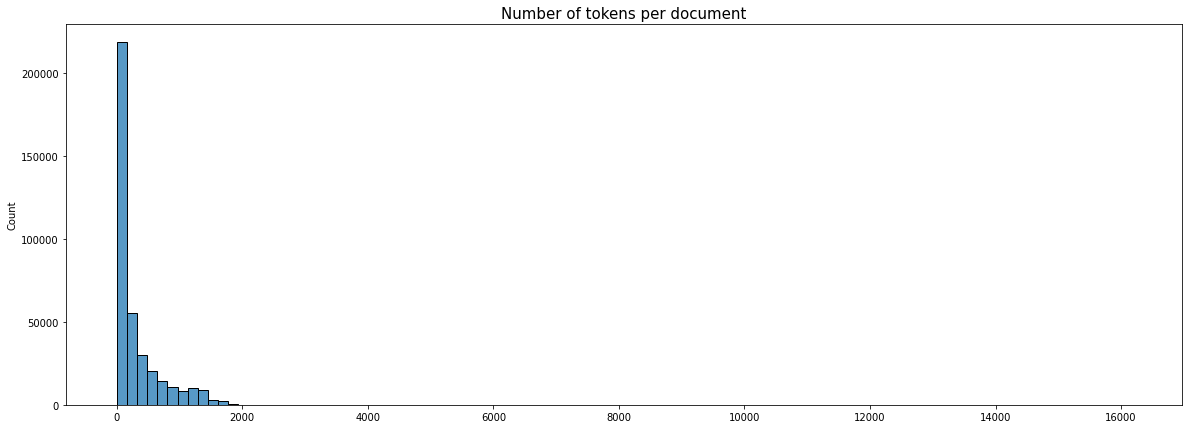

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

lens = [len(text.split()) for text in docs["text"]]

plt.figure(figsize=(20,7))
sns.histplot(x = lens, bins = 100)
plt.title("Number of tokens per document", size = 15)
plt.show()

In [ ]:
print(f"There are {np.sum(np.array(lens) == 0)} empty documents ")

There are 1 empty documents 


In [ ]:
print(f"Minimum length of documents: {np.min(lens)}")
print(f"Average length of documents: {np.mean(lens)}")
print(f"Maximum length of documents: {np.max(lens)}")

Minimum length of documents: 0
Average length of documents: 286.45706518187404
Maximum length of documents: 16162


#### Queries

Let's dive into queries

In [ ]:
display(queries.head())
print(f"\n\nNumber of queries: {len(queries)}")

,_id,title,text
0,1,,Should teachers get tenure?
1,2,,Is vaping with e-cigarettes safe?
2,3,,Should insider trading be allowed?
3,4,,Should corporal punishment be used in schools?
4,5,,Should social security be privatized?




Number of queries: 49


Let's see how a sample looks like

In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(queries))

query_text = queries.iloc[idx]["text"] 
query_id = queries.iloc[idx]["_id"]

print(f"QUERY ID: {query_id}\n")
print(f"QUERY TEXT: {query_text}")

QUERY ID: 3

QUERY TEXT: Should insider trading be allowed?


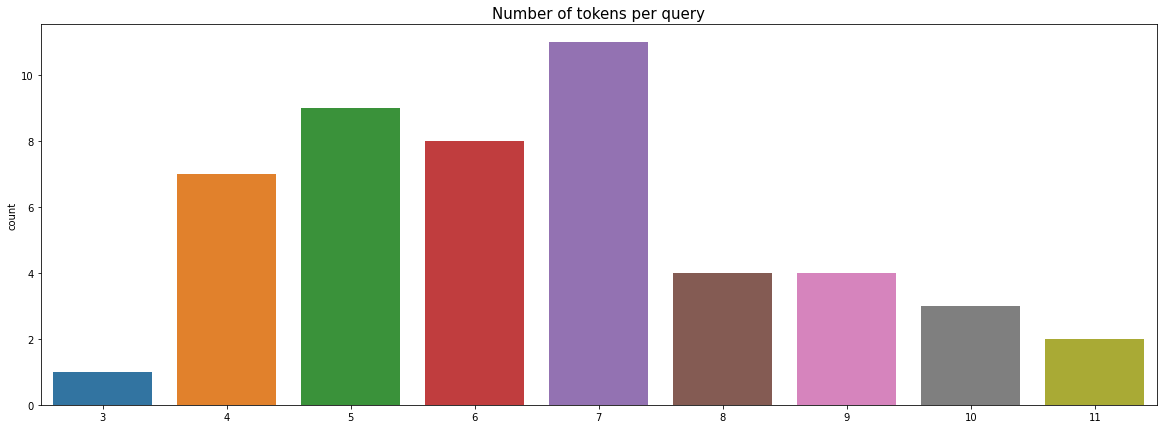

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

lens = [len(text.split()) for text in queries["text"]]

plt.figure(figsize=(20,7))
sns.countplot(x = lens)
plt.title("Number of tokens per query", size = 15)
plt.show()

In [ ]:
print(f"Average length of queries: {np.mean(lens)}")

Average length of queries: 6.551020408163265


#### Query relevance

Let's dive into the relevance label's dataset

In [ ]:
display(qrels.head())
print(f"\n\nNumber of labels: {len(qrels)}")

,query-id,corpus-id,score
9,1,4fb4627-2019-04-18T18:47:37Z-00003-000,1
20,1,30dbd85-2019-04-18T17:13:37Z-00004-000,1
21,1,ff0947ec-2019-04-18T12:23:12Z-00000-000,2
28,1,1b03f390-2019-04-18T18:42:36Z-00003-000,1
30,1,b0680508-2019-04-18T13:48:51Z-00002-000,2




Number of labels: 932


In [ ]:
print(f"Number of different queries: {qrels['query-id'].nunique()}")
print(f"Number of different docs: {qrels['corpus-id'].nunique()}")

Number of different queries: 49
Number of different docs: 920


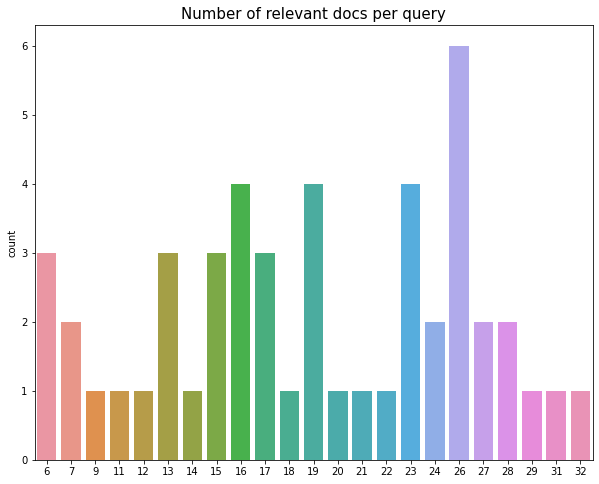

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

query_ids = qrels["query-id"].unique()

# Number of relevant documents per query
n_rels = [len(qrels[qrels["query-id"] == query_id]) for query_id in query_ids]

plt.figure(figsize = (10, 8))
sns.countplot(x = n_rels)
plt.title("Number of relevant docs per query", size = 15)
plt.show()

In [ ]:
idx = query_ids[np.argmax(n_rels)]

print(f"Average number of relevant documnets per query: {np.mean(n_rels)}")
print()
print(f"The query with more relevants docs is: {queries[queries['_id'] == idx]['text'].item()}")
print(f"It has {np.max(n_rels)} relevant documents")
print(f"95% of documents have less than {round(np.percentile(n_rels, 95))} relevants documents")

Average number of relevant documnets per query: 19.020408163265305

The query with more relevants docs is: Should students have to wear school uniforms?
It has 32 relevant documents
95% of documents have less than 29 relevants documents


In [ ]:
import numpy as np 
from pprint import pprint  
idx = np.random.randint(len(qrels))

doc_id = qrels.iloc[idx]["corpus-id"] 
query_id = qrels.iloc[idx]["query-id"]
label = qrels.iloc[idx]["score"]

doc_text = docs[docs["_id"] == doc_id]["text"].item()
query_text = queries[queries["_id"] == query_id]["text"].item()

print(f"QUERY TEXT: {query_text}\n\n")
print(f"DOC TEXT:")
pprint(doc_text)
print(f"\n\nLABEL: {label}")

QUERY TEXT: Should students have to wear school uniforms?


DOC TEXT:
('Well for one thing school uniforms make everything more bland which in this '
 "case is good, you wouldn't be distracted by all the fancy clothing kids "
 'wear. Second uniforms would cut down on a lot of bullying, because everybody '
 'is wearing the same clothes if someone makes fun of your outfit they are at '
 'the same time making fun of theirs. Second it makes it way easier to make '
 "sure that people aren't being inappropriate with their clothes, like no bra "
 'and a see through shirt. It really makes it easier to pick clothes for '
 'school which would cut down on stress levels with teens.')


LABEL: 2


### Preprocessing

We are going to tokenize each document. As this operation takes approximately 30 mins, I have saved them to my Google Drive, so to import the already preprocessed documents without wasting time. 

In [ ]:
# %time docs["cleaned_text"] = docs["text"].map(tokenizer)
# docs.to_csv("gdrive/MyDrive/touche_tokenized_documents.csv")

CPU times: user 30min 43s, sys: 6.74 s, total: 30min 49s
Wall time: 33min 54s


Import tokenized documents

In [ ]:
import pandas as pd

if on_drive:
  docs = pd.read_csv("gdrive/MyDrive/touche_tokenized_documents.csv", index_col = 0)
  docs["cleaned_text"] = docs["cleaned_text"].map(lambda x: x.replace("'", "").replace("[", "").replace("]", "").split(", "))
else: 
  docs["cleaned_text"] = docs["text"].map(tokenizer)

docs.sample(5)

Let's see how a tokenized document looks like

In [ ]:
import numpy as np
from pprint import pprint

idx = np.random.randint(len(docs))

print("DOCUMENT: ")
pprint(docs.iloc[idx]["text"])
print("\n\nTOKENIZED DOCUMENT: ")
print(docs.iloc[idx]["cleaned_text"])

DOCUMENT: 
('"I object to violence because when it appears to do good, the good is only '
 'temporary; the evil it does is permanent." Mahatma Gandhi No one has proven '
 'the point that violence is not the only option, nor is it the best option '
 'better than Gandhi. Because he was able to accomplish so much without using '
 'violence, I proudly stand on the Pro side of this topic. Resolved: On '
 'Balance, the Pen is Mightier than the Sword." At this point I will provide '
 'my interpretation of the topic. "On Balance" - when weighed against each '
 'other, the one that holds any advantage, no matter how substantial, is the '
 'best option. "The Pen" - the use of words and/or non-violent means to '
 'accomplish a desired goal "The Sword" - the use of force by means of '
 'inflicting physical harm upon one or more people to achieved a desired goal '
 'And with these things in mind, I would like to move to my first point of '
 'analysis - 1."Sticks and Stone may break my bones, but Wo

Save docs, queries and qrels in specific variables

In [ ]:
t_docs = docs
t_queries = queries
t_qrels = qrels

# *OVERVIEW OF THE MODELS*

We took some of the models and the general class structure by the library [rank-bm25](https://github.com/dorianbrown/rank_bm25). 

All the models come with similar attributes: 

* `model.corpus`      = the corpus of documents           
* `model.corpus_size` = the number of documents in the corpus
* `model.voc`         = the vocabulary 
* `model.voc_size`    = the number of words in the vocabulary 
* `model.doc_len`     = the list of the length of the documents
* `model.avgdl`       = the average of the above list  
* `model.doc_freqs`   = a list of vocabularies containing the occurrencies of each word per document
* `model.idf`         = the vocabulary of idfs for each word
* `model.tokenizer`   = the preprocessing function to tokenize documents and queries
* `model.nd`          = the document frequency for each word

And similar methods: 

* `model.get_scores(query)` = returns the scores for each document
* `model.get_batch_scores(query, documents_ids)` = returns the scores for a subset of the corpus, indexed by documents_ids
* `model.get_top_n(query, n, documents)` = return the n documents with the highest scores

The functioning of the models is explained with the *WikIR* dataset.

In [ ]:
docs = w_docs
queries = w_queries
qrels = w_qrels

## $TFIDF$

The base model that has been proposed is **TF-IDF**. There are several versions of this model, thta slighlty differs in how **TF** (term frequency) or **IDF** (inverse document frequency) are computed. Anyway the main idea is that TF accounts for the number of occurrencies od a term in a document, as a proxy for relevance, while IDF penalizes the most commoon terms in the corpus. It does so by scoring *rarity*:  If a term doesn’t occur in most documents in the corpus, then whenever it does occur, we’ll guess that this occurrence is significant. On the other hand, if a term occurs in most of the documents in our corpus, then the presence of that term in any particular document will lose its value as an indicator of relevance.

In our version of **TF-IDF**, we have computed TF and IDF as follows: 
> $$TF_{td} = \log(1 + tf_{td}), $$

Where $tf_{td}$ is the number of occurrencies of the term $t$ in doc $d$. And,  

> $$IDF_t = \log_{10}(N/df_t)$$

Where $df_t$ is the number of documents containing the term $t$. 

Finally we can compute the relevance score between a query $q$ and a document $d$ as: 

> $$TFIDF_{qd} = \sum_{t\in q}TF_{td} \cdot IDF_t$$

#### Class Definition 

In [ ]:
import math
import numpy as np
from multiprocessing import Pool, cpu_count
from time import time
import warnings

class TFIDF:
    def __init__(self, corpus=[], tokenizer=None):
        self.corpus = []              # corpus
        self.corpus_size = 0          # size of the corpus
        self.voc = []                 # vocabulary 
        self.voc_size = 0             # size of the vocabulary
        self.doc_len = []             # length of the documents 
        self.avgdl = 0                # average length of the documents 
        self.doc_freqs = []           # frequencies of word for every doc
        self.idf = {}                 # idf
        self.tokenizer = tokenizer    # tokenizer
        self.nd = {}                  # word -> number of documents with word


        if len(corpus) > 0:

          if tokenizer:
              print("Tokenizing the corpus ...")
              x = time()
              self.corpus = self._tokenize_corpus(corpus)
              x = time() - x
              print(f"Done! Time Elapsed: {x}")
          else: 
            self.corpus = corpus

          print("Computing tfs and creating the vocabulary ...")
          x = time()
          self._initialize()
          x = time() - x  
          print(f"Done! Time Elapsed: {x}")

          print("Computing idfs ...")
          x = time()
          self._calc_idf()
          x = time() - x    
          print(f"Done! Time Elapsed: {x}")
        
        else:
          warnings.warn("corpus not provided, remember to insert it before computing the scores!") 
          
    def _initialize(self):
        nd = {}      # word -> number of documents with word
        num_doc = 0  # total length of the corpus in words
        self.corpus_size = 0
        self.doc_freqs = []
        self.doc_len = []
        for document in self.corpus:
            self.doc_len.append(len(document))
            num_doc += len(document)

            frequencies = {}
            for word in document:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1
            self.doc_freqs.append(frequencies)

            for word, freq in frequencies.items():
                try:
                    nd[word]+=1
                except KeyError:
                    nd[word] = 1

            self.corpus_size += 1

        self.voc = list(nd.keys())
        self.voc_size = len(self.voc)
        self.avgdl = num_doc / self.corpus_size
        self.nd = nd

    def _tokenize_corpus(self, corpus):  
        pool = Pool(cpu_count())    # Parallelize tokenization between cpus
        tokenized_corpus = pool.map(self.tokenizer, corpus)
        return tokenized_corpus

    def _calc_idf(self):
        """
        Return the log of inverse document frequency
        """
        for word, freq in self.nd.items():              
            idf = math.log(self.corpus_size) - math.log(freq)
            self.idf[word] = idf

    def get_scores(self, query):
        """
        Calculate tfidf between query and all docs
        """

        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (np.log(1 + q_freq))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate tfidf scores between query and subset of all docs
        """

        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (np.log(1 + q_freq))

        return score.tolist()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

#### Utilization

Here we initialize the model by passing as input the corpus and the tokenizer. It will tokenize the corpus and compute $IDFs$. 

As the tokenization of the corpus takes almost 18 mins, from now on we are going to initialize models by passing the stored tokenized corpus and run the methods `model._initialize()` and `model._calc_idf()` manually, as shown in the successive cell.



In [ ]:
#tfidf = TFIDF(docs["text_right"], 
#              tokenizer = tokenizer)

Tokenizing the corpus ...
Done! Time Elapsed: 1319.047516822815
Computing tfs and creating the vocabulary ...
Done! Time Elapsed: 32.45748496055603
Computing idfs ...
Done! Time Elapsed: 0.6898038387298584


In [ ]:
tfidf = TFIDF(tokenizer = tokenizer)

tfidf.corpus = docs["cleaned_text"]
tfidf._initialize()
tfidf._calc_idf()

Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {tfidf.corpus_size}")
print(f"Vocabulary size: {tfidf.voc_size}")
print(f"Average length of documents: {tfidf.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's see which is the token with the lowest idf, namely the one that appears in more documents

In [ ]:
idx = np.argmin(list(tfidf.idf.values()))
word = list(tfidf.idf.keys())[idx]
print(f"Token with highest IDF: {word}")
print(f"IDF({word}) = {tfidf.idf[word]}")

Token with highest IDF: first
IDF(first) = 0.9409442955110805


Let's do a simple experiment to see how it works

In [ ]:
query_id = qrels.iloc[0]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(tfidf.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: yanni
Number of relevant docs: 6
Shape of the scores array: (369721,)
Amount of non zero scores: 39


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [123839, 1793430, 806300, 806075, 836567, 806263]
Pred Ids: [806300, 123839, 836567, 806326, 1793430, 2112227]


We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 0.67
Mean Average Precision: 0.87


Let's plot the plots of Precision@K and Recall@K varying K

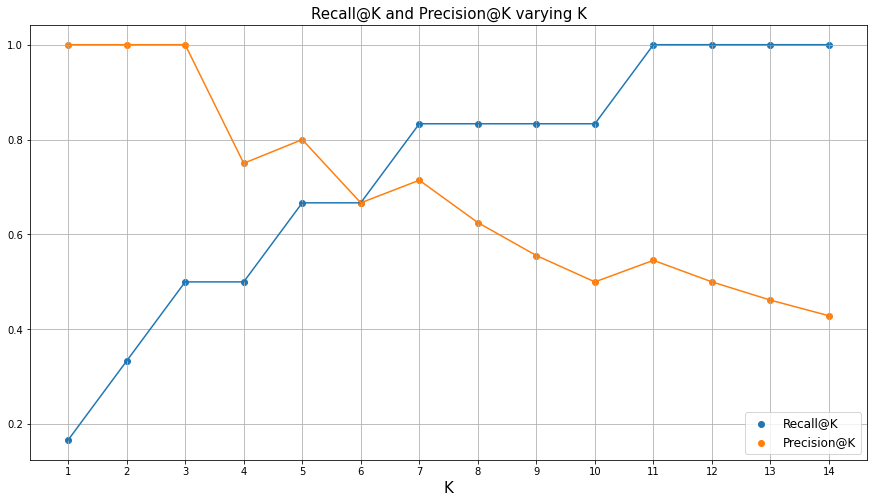

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

We can notice the breakeven point of precision-recall to be at K equal to 6.

## $BM25$ Family

TF-IDF comes with several limitations and several improvements have been proposed. Nowdays, the family of **BM25** models represent the state of the art of bag-of-words retrieval methods.  BM25 is a ranking function based on the porbabilistic retrieval framework developed in the 1970s and 1980s by Stephen E. Robertson, Kaern Sparck Jones, and others. Let's see the limitations of TF-IDF and how BM25 solves those limitations (for an exhaustive explanation see [here](https://kmwllc.com/index.php/2020/03/20/understanding-tf-idf-and-bm-25/)). 

**Term Saturation.** How should the ranking grow as the occurrencies of a term gorw in a specific document? Our TF-IDF implementation exploits the log of the occurrencies, so to make the ranking grow in logarithmic scale with respect to the term occurrencies. BM25 proposes another method: to control the saturation, BM25 uses the formula 

$$\frac{tf_{td}}{tf_{td} + k_1}.$$

Where $k_1$ is a constant that controls how rapidly the contribution approaches the upper bound of $TF$. Indeed the formula grows in a hyperbolic fashion and approaches $1$ as $tf_{td}$ goes to infinity. This formula comes with a fortunate side effect: if we have a query with more than one terms, let's say two, this ranking function has higher value in documents that contains one occurrency for each term, than 2 occurrencies of the same term.   

An interpretation of $k_1$ is that for documents of the average length, it is the value of the term frequency that gives a score of half the maximum score for the considered term.

**Document Length.** If a document happens to be really short and contains a particular keyword, it's a good indicator that that document is *about* that term, while we can't say the same for long documents. So we wuold like to penalize long documents. To achieve it, we adjust up $k_1$ if the document is longer than the average lenghth of the documents in the corpus, and adjust it down if the document is shorter than average, by multuplying $k_1$ by a factor that depends on the ratio $L_d / L_{avg}$, where $L_d$ is the document's length and $L_{avg}$ is the average document length across the corpus. 

To fine-tune the importance of the document length in the ranking we introduce another parameter $b$ (between $0$ and $1$), and multiply the $k_1$ by: 
$$1 - b + b \frac{L_d}{L_{avg}}.$$

**To sum up**, the final BM25 formula between a query $q$ and a document $d$ is: 
$$BM25_{q, d} = \sum_{t\in q} {IDF_t \cdot \frac{tf_{td}}{tf_{td} + k_1 \cdot (1-b+b\cdot \frac{L_d}{L_{avg}})}}$$

Usually $k_1 \in [1.2, 2.0]$ and $b = 0.75.$

It happens that some variants of the $IDF$ function produce negative values. We don’t want negative values coming out of our ranking function because the presence of a query term in a document should never count against retrieval — it should never cause a lower score than if the term was simply absent. The variants of $BM25$ that I am goiing to present solve that issue in different ways. 

From that general idea, several variants have been porposed. We will implement some of them [[2](#ref)][[3](#ref)]: 

* $BM25 \ Okapi$
* $BM25 \ Lucene$
* $BM25 \ ATARI$
* $BM25L$
* $BM25+$
* $BM25 \ Adpt$
* $TF_{l\circ\delta\circ p}\times IDF$

#### Class definition

This is the class from which above which we will build any other BM25 model.

In [ ]:
import warnings

class BM25:
    def __init__(self, corpus = [], tokenizer=None):
        self.corpus = []              # corpus
        self.corpus_size = 0          # size of the corpus
        self.voc = []                 # vocabulary 
        self.voc_size = 0             # size of the vocabulary
        self.doc_len = []             # length of the documents 
        self.avgdl = 0                # average length of the documents 
        self.doc_freqs = []           # frequencies of word for every doc
        self.idf = {}                 # idf
        self.tokenizer = tokenizer    # tokenizer
        self.nd = {}                  # word -> number of documents with word

        if len(corpus) > 1: 

          if tokenizer:
              print("Tokenizing the corpus ...")
              x = time()
              self.corpus = self._tokenize_corpus(corpus)
              x = time() - x
              print(f"Done! Time Elapsed: {x}")
          else: 
            self.corpus = corpus

          print("Computing tfs and creating the vocabulary ...")
          x = time()
          self._initialize()
          x = time() - x  
          print(f"Done! Time Elapsed: {x}")

          print("Computing idfs ...")
          x = time()
          self._calc_idf()
          x = time() - x    
          print(f"Done! Time Elapsed: {x}")

        else: 
          warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")

        
    def _initialize(self):
        nd = {}      # word -> number of documents with word
        num_doc = 0  # total length of the corpus in words
        self.corpus_size = 0
        self.doc_freqs = []
        self.doc_len = []
        for document in self.corpus:
            self.doc_len.append(len(document))
            num_doc += len(document)

            frequencies = {}
            for word in document:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1
            self.doc_freqs.append(frequencies)

            for word, freq in frequencies.items():
                try:
                    nd[word]+=1
                except KeyError:
                    nd[word] = 1

            self.corpus_size += 1

        self.voc = list(nd.keys())
        self.voc_size = len(self.voc)
        self.avgdl = num_doc / self.corpus_size
        self.nd = nd

    def _tokenize_corpus(self, corpus):  
        pool = Pool(cpu_count())    # Parallelize tokenization between cpus
        tokenized_corpus = pool.map(self.tokenizer, corpus)
        return tokenized_corpus

    def _calc_idf(self, nd):
        raise NotImplementedError()

    def get_scores(self, query):
        raise NotImplementedError()

    def get_batch_scores(self, query, doc_ids):
        raise NotImplementedError()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

### $BM25Okapi$

This is an adaptation of the original version [[3](#ref)], with slight improvements. 

Robertson et al. has proposed a variant of $IDF$, called $probabilistic \ IDF$. It is computed as: 
$$IDF_t = \log \left ( \frac{N - df_t + 0.5}{df_t + 0.5}\right )$$

To derive it teorethically we should go through the Robertson-Sparck Jones weights, but it goes beyond the scope of this project. Anyway to understand its behaviour we observe that it takes negative values approximately when the term appears in more than half the documents in the corpus. 

To deal with negative values, we set a lower bound to $IDFs$ to the average $IDF$ across all the terms in the vocabulary multiplyed by a constant $\epsilon$, that we set to $0.25.$

The final formula is: 

$$\sum_{t\in q} \log\left( \frac{N - df_t + 0.5}{df_t + 0.5} \right) \cdot \frac{tf_{td}} {tf_{td} + k_1 \cdot (1-b+b\cdot \frac{L_d}{L_{avg}})}$$

#### Class Definition

In [ ]:
class BM25Okapi(BM25):
    """
    Original Formulation by Robertson et al. 
    """
    def __init__(self, corpus = [], tokenizer=None, k1=1.5, b=0.75, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        self.average_idf = 0
        super().__init__(corpus, tokenizer)

    def _calc_idf(self):
        """
        Robertson-Sparck Jones IDF. It produces negative scores when df > /2
        Calculates frequencies of terms in documents and in corpus.
        This algorithm sets a floor on the idf values to eps * average_idf
        """
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in self.nd.items():
            idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps

    def get_scores(self, query):
        """
        Calculate bm25 scores for every document
        """
        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (q_freq /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """

        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (q_freq /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))

        return score.tolist()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

#### Utilization

In [ ]:
bm25 = BM25Okapi(tokenizer = tokenizer)

bm25.corpus = docs["cleaned_text"]
bm25._initialize()
bm25._calc_idf()

<ipython-input-56-a09ff859993c>:38: UserWarning: Corpus not provided. Remember to insert it before computing the scores !
  warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")


Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {bm25.corpus_size}")
print(f"Vocabulary size: {bm25.voc_size}")
print(f"Average length of documents: {bm25.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's see which is the token with the lowest idf, namely the one that appears in more documents

In [ ]:
idx = np.argmin(list(bm25.idf.values()))
word = list(bm25.idf.keys())[idx]
print(f"Token with highest IDF: {word}")
print(f"IDF({word}) = {bm25.idf[word]}")

Token with highest IDF: first
IDF(first) = 0.4462218141764609


Let's do a simple experiment to see how it works

In [ ]:
query_id = qrels.iloc[0]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(bm25.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: yanni
Number of relevant docs: 6
Shape of the scores array: (369721,)
Amount of non zero scores: 39


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [123839, 1793430, 806300, 806075, 836567, 806263]
Pred Ids: [806300, 123839, 836567, 806326, 1793430, 2112227]


We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 1.0
Mean Average Precision: 0.78


Let's plot the plots of Precision@K and Recall@K varying K

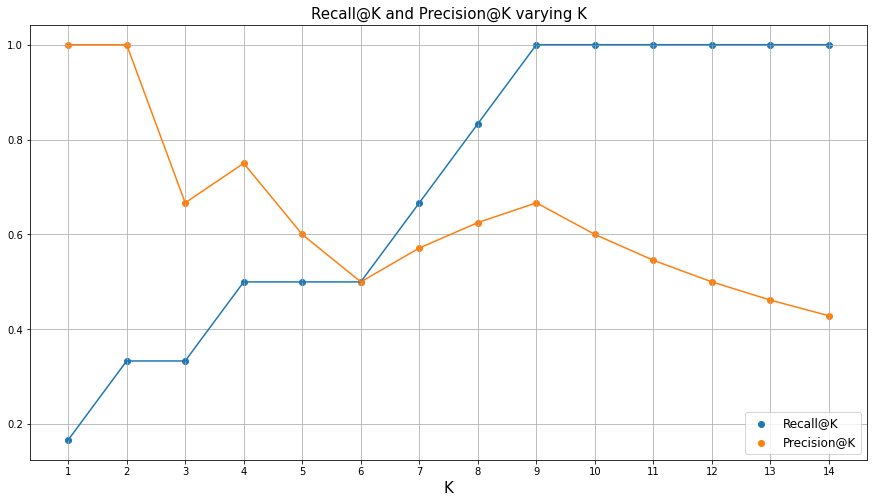

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

We can notice the breakeven point of precision-recall to be at K equal to 6.

### $BM25Lucene$

In the Lucene implementation, the only difference is how the negative values of $IDFs$ are managed: the $IDF$ formula is redefined as follows:

$$IDF_t = \log \left ( \frac{N - df_t + 0.5}{df_t + 0.5} +1 \right )$$

In this way, it can never take negative values.

The final formula is: 

$$\sum_{t\in q} \log \left ( \frac{N - df_t + 0.5}{df_t + 0.5} +1 \right ) \cdot \frac{tf_{td}} {tf_{td} + k_1 \cdot (1-b+b\cdot \frac{L_d}{L_{avg}})}$$


#### Class Definition

In [ ]:
class BM25Lucene(BM25):
    """
    BM25 Lucene
    Actually Lucene use a document length compressed in a lossy manner 
    to a one byte value. It gets only 256 distinct document lengths,
    in order to pre-compute the value: k1 * (1 - b + b*(L_lossy / L_avg))
    """
    def __init__(self, corpus = [], tokenizer=None, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.average_idf = 0
        super().__init__(corpus, tokenizer)

    def _calc_idf(self):
        """
        Calculates frequencies of terms in documents and in corpus.
        """
        idf_sum = 0
        for word, freq in self.nd.items():
            idf = math.log(1 + (self.corpus_size - freq + 0.5)/(freq + 0.5))
            self.idf[word] = idf
            idf_sum += idf
        self.average_idf = idf_sum / len(self.idf)

    def get_scores(self, query):
        """
        computes bm25 for every document
        """
        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (q_freq /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (q_freq /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score.tolist()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

#### Utilization

In [ ]:
bm25 = BM25Lucene(tokenizer = tokenizer)

bm25.corpus = docs["cleaned_text"]
bm25._initialize()
bm25._calc_idf()

<ipython-input-56-a09ff859993c>:38: UserWarning: Corpus not provided. Remember to insert it before computing the scores !
  warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")


Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {bm25.corpus_size}")
print(f"Vocabulary size: {bm25.voc_size}")
print(f"Average length of documents: {bm25.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's see which is the token with the lowest idf, namely the one that appears in more documents

In [ ]:
idx = np.argmin(list(bm25.idf.values()))
word = list(bm25.idf.keys())[idx]
print(f"Token with highest IDF: {word}")
print(f"IDF({word}) = {bm25.idf[word]}")

Token with highest IDF: first
IDF(first) = 0.9409435349399955


Let's do a simple experiment to see how it works

In [ ]:
query_id = qrels.iloc[0]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(bm25.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: yanni
Number of relevant docs: 6
Shape of the scores array: (369721,)
Amount of non zero scores: 39


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [123839, 1793430, 806300, 806075, 836567, 806263]
Pred Ids: [806300, 123839, 806326, 836567, 2112227, 2355277]


We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 0.5
Mean Average Precision: 0.75


Let's plot the plots of Precision@K and Recall@K varying K

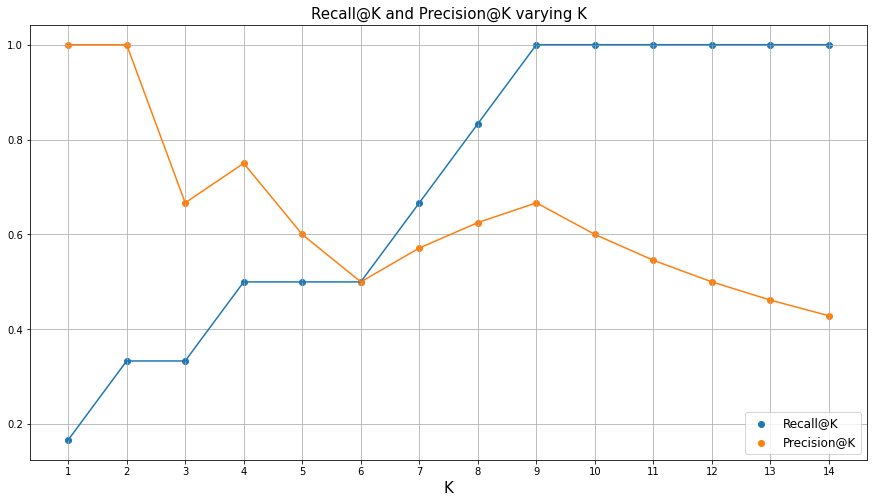

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

We can notice the breakeven point of precision-recall to be at K equal to 6.

### $BM25 ATIRE$

In the ATIRE [[5](#ref)] implementation substitutes the probabilistic $IDF$ with the original definition of $IDF$: 

$$IDF_t = \log \left ( \frac{N}{df_t} \right ).$$

Even this implementation avoids negative values. 
The $TF$ component is multiplied by $(k_1 + 1)$ to make it look more like the Robertson-Sparck Jones weight, but it doesn't affect teh ranked list, as all scores are scaled linearly with this factor.  

The final formula is: 

$$\sum_{t\in q} \log \left ( \frac{N}{df_t} \right ) \cdot \frac{tf_{td} \cdot (1+k_1)} {tf_{td} + k_1 \cdot (1-b+b\cdot \frac{L_d}{L_{avg}})}$$

#### Class Definition

In [ ]:
class BM25ATIRE(BM25):
    """
    ATIRE Variant 
    """
    def __init__(self, corpus = [], tokenizer=None, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.average_idf = 0
        super().__init__(corpus, tokenizer)

    def _calc_idf(self):
        """
        Return the log of inverse document frequency
        """
        for word, freq in self.nd.items():              
            idf = math.log(self.corpus_size) - math.log(freq)
            self.idf[word] = idf

    def get_scores(self, query):
        """
        conmputes bm25 for every document
        The TF component is multiplied by k1+1
        """
        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * ((self.k1 + 1)* q_freq /
                                                 (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score.tolist()
      
    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

#### Utilization

In [ ]:
bm25 = BM25ATIRE(tokenizer = tokenizer)

bm25.corpus = docs["cleaned_text"]
bm25._initialize()
bm25._calc_idf()

<ipython-input-56-a09ff859993c>:38: UserWarning: Corpus not provided. Remember to insert it before computing the scores !
  warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")


Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {bm25.corpus_size}")
print(f"Vocabulary size: {bm25.voc_size}")
print(f"Average length of documents: {bm25.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's see which is the token with the lowest idf, namely the one that appears in more documents

In [ ]:
idx = np.argmin(list(bm25.idf.values()))
word = list(bm25.idf.keys())[idx]
print(f"Token with highest IDF: {word}")
print(f"IDF({word}) = {bm25.idf[word]}")

Token with highest IDF: first
IDF(first) = 0.9409442955110805


Let's do a simple experiment to see how it works

In [ ]:
query_id = qrels.iloc[0]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(bm25.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: yanni
Number of relevant docs: 6
Shape of the scores array: (369721,)
Amount of non zero scores: 39


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [123839, 1793430, 806300, 806075, 836567, 806263]
Pred Ids: [806300, 123839, 806326, 836567, 2112227, 2355277]


We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 0.5
Mean Average Precision: 0.75


Let's plot the plots of Precision@K and Recall@K varying K

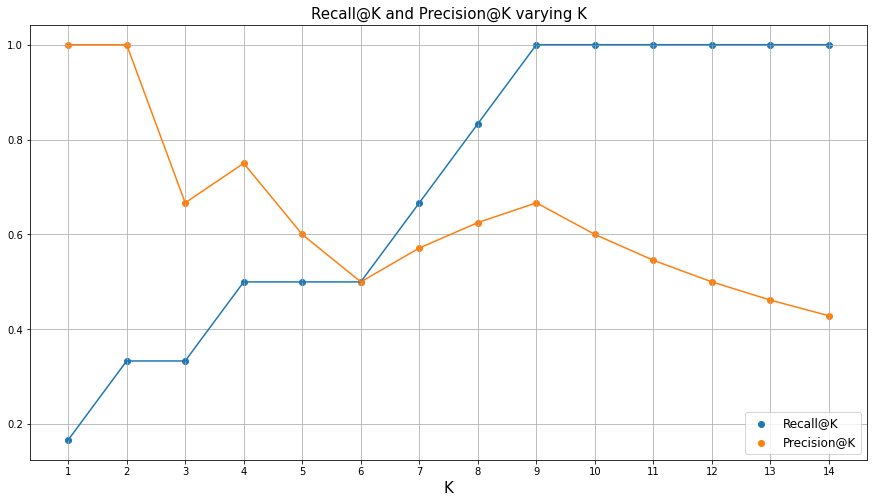

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

We can notice the breakeven point of precision-recall to be at K equal to 6.

### $BM25L$

$BM25L$ [[6](#ref)] borns from the observation that $BM25$ penalizes longer documents too much compared to shorter ones.

 The $IDF$ component is defined as 
$$IDF_t = \log \left ( \frac{N+1}{df_t+0.5}\right )$$
to avoid negative values.

The $TF$ component is reformulated as $((k_1+1)\cdot c_{td})(k_1+c_{td})$ with $c_{td}= tf_{td} / (1-b+b\cdot (L_d/L_{avg}))$. It is further modified by adding a constant $\delta$, boosting the score for longer documents,  This has the effect of shifting the function to better favor small numbers (i.e. large denominators, equivalently large $L_d$ values, or long documents). The authors report $\delta = 0.5$ for highest effectiveness.

The final formula is:

$$\sum_{t\in q} \log \left ( \frac{N+1}{df_t+0.5}\right ) \cdot \frac{(k_1 +1)\cdot (c_{td}+\delta)} {k_1 + c_{td} + \delta}$$

#### Class Definition

In [ ]:
class BM25L(BM25):
    """
    BM25L more suited for long documents
    It penalizes less long docs
    """

    def __init__(self, corpus = [], tokenizer=None, k1=1.5, b=0.75, delta=0.5):
        # Algorithm specific parameters
        self.k1 = k1
        self.b = b
        self.delta = delta
        super().__init__(corpus, tokenizer)

    def _calc_idf(self):
        """
        Computes idf for each word
        """
        for word, freq in self.nd.items():
            idf = math.log(self.corpus_size + 1) - math.log(freq + 0.5)
            self.idf[word] = idf

    def get_scores(self, query):
        """
        Computes bm25 for every document 
        """
        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
            score += (self.idf.get(q) or 0) * (self.k1 + 1) * (ctd + self.delta) / \
                     (self.k1 + ctd + self.delta)
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
            score += (self.idf.get(q) or 0) * (self.k1 + 1) * (ctd + self.delta) / \
                     (self.k1 + ctd + self.delta)
        return score.tolist()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]


#### Utilization

In [ ]:
bm25 = BM25L(tokenizer = tokenizer)

bm25.corpus = docs["cleaned_text"]
bm25._initialize()
bm25._calc_idf()

<ipython-input-56-a09ff859993c>:38: UserWarning: Corpus not provided. Remember to insert it before computing the scores !
  warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")


Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {bm25.corpus_size}")
print(f"Vocabulary size: {bm25.voc_size}")
print(f"Average length of documents: {bm25.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's see which is the token with the lowest idf, namely the one that appears in more documents

In [ ]:
idx = np.argmin(list(bm25.idf.values()))
word = list(bm25.idf.keys())[idx]
print(f"Token with highest IDF: {word}")
print(f"IDF({word}) = {bm25.idf[word]}")

Token with highest IDF: first
IDF(first) = 0.9409435349399953


Let's do a simple experiment to see how it works

In [ ]:
query_id = qrels.iloc[0]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(bm25.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: yanni
Number of relevant docs: 6
Shape of the scores array: (369721,)
Amount of non zero scores: 369721


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [123839, 1793430, 806300, 806075, 836567, 806263]
Pred Ids: [806300, 123839, 806326, 836567, 2112227, 2355277]


We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 0.5
Mean Average Precision: 0.75


Let's plot the plots of Precision@K and Recall@K varying K

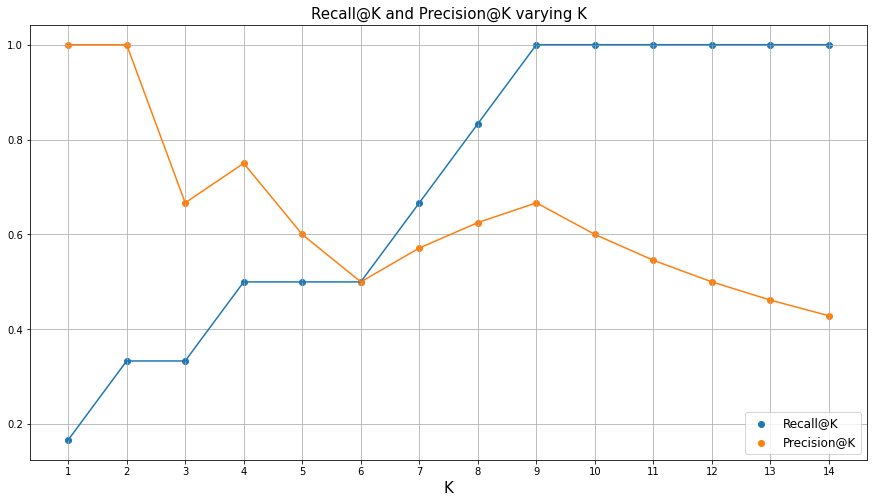

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

We can notice the breakeven point of precision-recall to be at K equal to 6.

###$BM25+$

Even this version [[7](#ref)] borns with the aim of dealing with the issue that ranking functions unfairly prefer shorter documents over longer ones. The proposal is to add a lower-bound bonus when a term appears at least one time in a document. The diﬀerence with $BM25L$ is a constant $\delta$ to the $TF$ component. The $IDF$ component is again changed to a variant that disallows negative values.

The final formula is: 

$$\sum_{t\in q} \log \left ( \frac{N+1}{df_t}\right ) \cdot \left( \frac{(k_1 +1)\cdot tf_{td}} {k_1 \cdot (1-b+b \cdot \frac{L_d}{L_{avg}}) + tf_{td}} + \delta \right )$$

#### Class Definition

In [ ]:
class BM25Plus(BM25):
    """
    BM25+ version
    """
    def __init__(self, corpus = [], tokenizer=None, k1=1.5, b=0.75, delta=1):
        # Algorithm specific parameters
        self.k1 = k1
        self.b = b
        self.delta = delta
        super().__init__(corpus, tokenizer)

    def _calc_idf(self):
        for word, freq in self.nd.items():
            idf = math.log((self.corpus_size + 1) / freq)
            self.idf[word] = idf

    def get_scores(self, query):
        """
        Computes bm25 for every document
        """
        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (self.delta + (q_freq * (self.k1 + 1)) /
                                               (self.k1 * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (self.delta + (q_freq * (self.k1 + 1)) /
                                               (self.k1 * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score.tolist()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

#### Utilization

In [ ]:
bm25 = BM25Plus(tokenizer = tokenizer)

bm25.corpus = docs["cleaned_text"]
bm25._initialize()
bm25._calc_idf()

<ipython-input-56-a09ff859993c>:38: UserWarning: Corpus not provided. Remember to insert it before computing the scores !
  warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")


Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {bm25.corpus_size}")
print(f"Vocabulary size: {bm25.voc_size}")
print(f"Average length of documents: {bm25.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's see which is the token with the lowest idf, namely the one that appears in more documents

In [ ]:
idx = np.argmin(list(bm25.idf.values()))
word = list(bm25.idf.keys())[idx]
print(f"Token with highest IDF: {word}")
print(f"IDF({word}) = {bm25.idf[word]}")

Token with highest IDF: first
IDF(first) = 0.9409470002496468


Let's do a simple experiment to see how it works

In [ ]:
query_id = qrels.iloc[0]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(bm25.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: yanni
Number of relevant docs: 6
Shape of the scores array: (369721,)
Amount of non zero scores: 369721


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [123839, 1793430, 806300, 806075, 836567, 806263]
Pred Ids: [806300, 123839, 806326, 836567, 2112227, 2355277]


We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 0.5
Mean Average Precision: 0.75


Let's plot the plots of Precision@K and Recall@K varying K

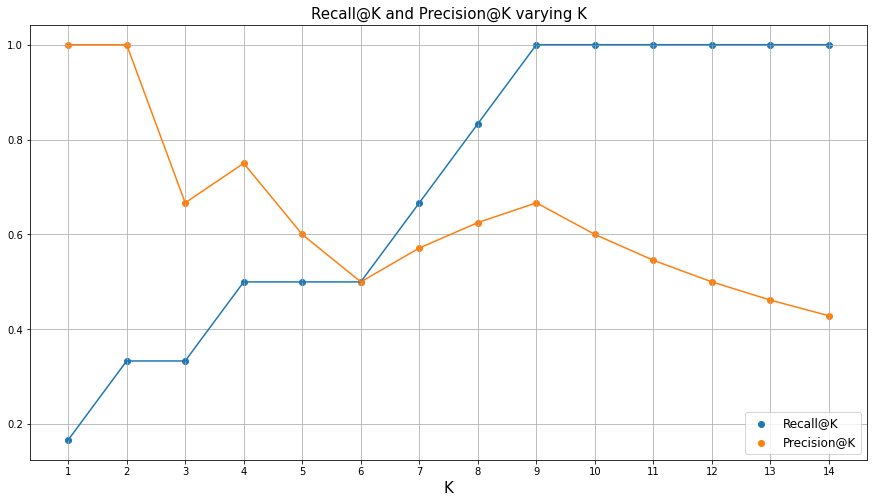

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

We can notice the breakeven point of precision-recall to be at K equal to 6.

### $BM25Adpt$

$BM25Adpt$ [[8](#ref)] is an approach that adapts $k_1$ for each term. To do so it starts by identifying the probability of a term occurring at least once in a document as $(df_{tr} + 0.5)/(N+1)$. The probability of the term occurring one more time is then deﬁned as $(df_{r+1} +0.5)/(df_r+ 1)$. The information gain of a term occurring $r + 1$ instead of $r$ times is deﬁned as 

$$G^r_q= \log_2 \left (\frac{df_{r+1} +0.5}{df_r +1}\right ) −\log_2\left ( \frac{df_{tr} +0.5}{N+1}\right),$$ 

where $df_r$ is deﬁned as follows: 

$$|\{D \ | \ c_{td} \ge r−0.5\}| \quad if \quad  r>1, \\ df_t \quad if \quad r=1,\\N \quad if \quad r=0$$

where $c_{td}$ is the same as in $BM25L$. That is to say, for the base case of $r = 0$, the number of documents in the collection is used; when $r = 1$, the document frequency is used; in all other cases, $|\{D \ | \ c_{td} \ge r−0.5\}|$, the number of documents, $|D|$, containing the term, $t$, that have a length normalized occurrence count, $c_{td}$, greater than $r$ (once rounded). The information gain is calculated for $r \in \{0,...,T\}$, until $G^r_q>G^{r+1}_q$. The optimal value for $k_1$ is then determined by ﬁnding the value for $k_1$ that minimizes the equation

$$k_1^* = argmin_{k_1}\sum_{r=0}^T \left ( \frac{G^r_q}{G^1_q}−\frac{(k_1+1)·r}{k_1+r} \right ) ^2.$$



Essentially, this gives avalue for $k_1 $that maximizes information gain for that speciﬁc term; $k_1^*$ and $G^1_q$ are then plugged into the $BM25Adpt$ formula, that is: 

$$\sum_{t\in q} G_q^1 \cdot \frac{(k_1^* +1) \cdot tf_{td}}{k_1^* \cdot (1-b+b\cdot(\frac{L_d}{L_{avg}})) + tf_{td}}$$

To compute the $k_1^*$ we have opted for a very simple solution: we try each value of $k_1 \in [0.001 , 2.5]$ with an increasing step of $0.001$ and take the one that minimizes the equation above. 

Kamphuis C. et al. [[3](#ref)] found that the optimal value of $k_1$ is actually not deﬁned for about $90 \%$ of the terms. A unique optimal value for $k_1$ only exists when $r>1$ while calculating $G^r_q$. For many terms, especially those with a low $df$ ,$G^r_q>G^{r+1}_q$ occurs before $r>1$. In these cases, picking different values for $k_1$ has virtually no effect on retrieval effectiveness. For undefined values, we set $k_1$ to $0.001$, the same as Trotman et al. [[2](#ref)].

#### Class Definition

In [ ]:
class BM25Adpt(BM25):
    """
    BM25 with adaptive K
    """

    def __init__(self, corpus = [], tokenizer = None,  b=0.75):
        # Algorithm specific parameters
        self.b = b
        super().__init__(corpus, tokenizer)

    def _dfr(self, q, r):
      if r == 0:
        return self.corpus_size
      elif r == 1:
        return self.nd.get(q) or 0
      else: 
        return np.sum(self.ctd - r + 0.5 > 0)
    
    def _G(self, q, r):
      return math.log(self._dfr(q, r+1) + 0.5, 2) - math.log(self._dfr(q, r) + 1, 2) - \
          math.log(((self.nd.get(q) or 0) / self.corpus_size) + 0.5, 2) + math.log(self.corpus_size + 1, 2)

    def _calc_k(self, q):
      """
      Computes k given a query term
      """

      # Computing information gains until G(q, r) > G(q, r+1)
      Gs = [self._G(q, 0), self._G(q, 1)]
      r=2
      while True:
        if self._G(q, r) > Gs[-1]:
          Gs.append(self._G(q, r))
          r+=1
        else:
          break  

      # If G(q, r) > G(q, r+1) happens for r = 1, the optimal value of k is undefined,
      # we set k = 0.001, as in Trotman et al.
      if len(Gs) == 2:
        return 0.001
      
      ks = np.arange(0.001, 2.5, 0.001)                # array of candidates k
      res_to_minimize = np.array([np.sum([
          (Gs[i] / Gs[1] - (k + 1) * i / (k + i))**2 
          for i in range(len(Gs))]
          ) for k in ks])

      return ks[np.argmin(res_to_minimize)]
        

    def get_scores(self, query):
        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            self.ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
            k = self._calc_k(q)
            score += (self._G(q, 1)) * (q_freq * (k + 1) /
                                              (k * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            self.ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
            k = self._calc_k(q)
            score += (self._G(q, 1)) * (q_freq * (k + 1) /
                                              (k * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score.tolist()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

#### Utilization

In [ ]:
bm25 = BM25Adpt(tokenizer = tokenizer)

bm25.corpus = docs["cleaned_text"]
bm25._initialize()
#bm25._calc_idf()

<ipython-input-13-60e16a449dc8>:40: UserWarning: Corpus not provided. Remember to insert it before computing the scores !
  warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")


Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {bm25.corpus_size}")
print(f"Vocabulary size: {bm25.voc_size}")
print(f"Average length of documents: {bm25.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's do a simple experiment to see how it works

In [ ]:
import numpy as np
import math

idx = np.random.randint(len(qrels))
query_id = qrels.iloc[idx]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"TOKENIZED QUERY: {tokenizer(query)}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(bm25.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: united kingdom
TOKENIZED QUERY: ['unit', 'kingdom']
Number of relevant docs: 2759
Shape of the scores array: (369721,)
Amount of non zero scores: 63016


In [ ]:
for q in tokenizer(query):
  print(f"K optimized for {q}: {bm25._calc_k(q)}")

K optimized for unit: 0.41700000000000004
K optimized for kingdom: 0.122


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [13540, 1728654, 1907561, 505354, 163766, 1578090, 2056171, 178885, 2455917, 424509, 360535, 854184, 1206244, 863730, 491280, 278514, 761671, 245767, 225612, 210131, 1670064, 415534, 1859469, 1554905, 232614, 1296264, 285682, 1678554, 1336799, 1170559, 778006, 1433174, 965438, 1677039, 236410, 597993, 413412, 424875, 1383445, 778468, 1107523, 1285983, 918722, 1276050, 648254, 2108179, 712189, 2051486, 172457, 949381, 830028, 288256, 857790, 709909, 1433860, 1334025, 1334508, 952270, 597178, 2321883, 1354797, 2280543, 1803182, 2039423, 316835, 570254, 2315013, 1147332, 189241, 889977, 1472431, 1001910, 1335049, 1228269, 1565974, 708370, 78062, 2084409, 730430, 1438142, 294402, 941522, 426211, 1657598, 481617, 2021049, 898144, 1491920, 46169, 1952645, 1767245, 2097347, 1800087, 736580, 851113, 2298604, 307810, 109020, 1208009, 238034, 670655, 1310779, 1258505, 123282, 1021609, 627781, 1294774, 1433013, 379615, 1899682, 1989895, 2028036, 253285, 157495, 250071, 1485219, 285376, 

We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 0.05
Mean Average Precision: 0.08


Let's plot the plots of Precision@K and Recall@K varying K

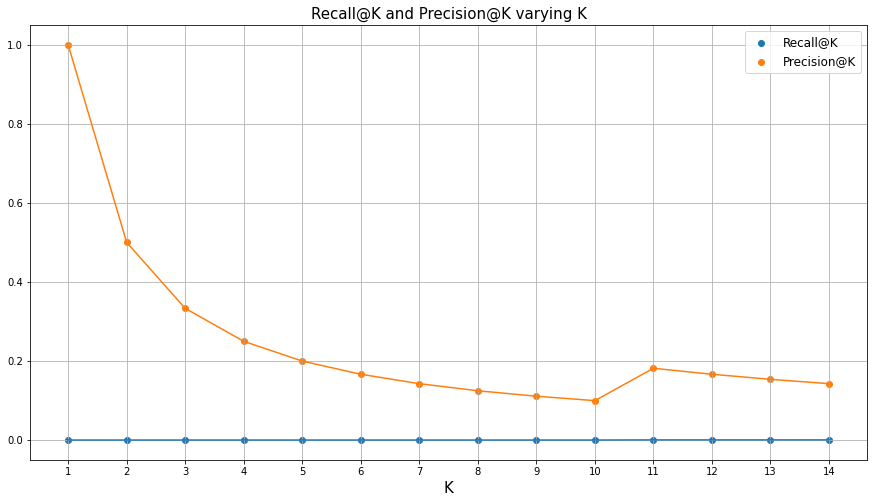

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

### $TF_{l\circ\delta\circ p}\times IDF$

Rousseau & Vazirgiannis [[9](#ref)] suggest that nonlinear gain from
observing an additional occurrence of a term in a document
should be modeled using a log function thus: 

$$TF_{td} = 1 + \log(1 + \log(tf_{td}))$$

Following $BM25+$ they add $\delta$ to ensure there is a sufficient gap between the $0^{th}$ and $1^{st}$ term occurence, and than they apply the usual length normalization component of $BM25$. The $IDF$ function is the same as $BM25+$.

The final formula is: 

$$\sum_{t\in q} \log \left ( \frac{N+1}{df_t}\right ) \cdot  \left( 1+\log\left(1+\log\left(\frac{tf_{td}}{1-b+b\cdot \frac{L_d}{L_{avg}}} + \delta\right)\right)\right )$$

#### Class definition

In [ ]:
class TFIDFldp(BM25):
    def __init__(self, corpus = [],tokenizer = None,  b=0.75, delta = 1):
        # Algorithm specific parameters
        self.b = b
        self.delta = delta
        super().__init__(corpus, tokenizer)

    def _calc_idf(self):
        for word, freq in self.nd.items():
            idf = math.log((self.corpus_size + 1) / freq)
            self.idf[word] = idf

    def get_scores(self, query):
        query = self.tokenizer(query)

        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)

        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (1 + np.log(1 + np.log(
                q_freq / (1 - self.b + self.b * doc_len / self.avgdl) + self.delta
                )))
            
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        query = self.tokenizer(query)

        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (1 + np.log(1 + np.log(
                q_freq / (1 - self.b + self.b * doc_len / self.avgdl) + self.delta
                )))
        return score.tolist()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

#### Utilization

In [ ]:
bm25 = TFIDFldp(tokenizer = tokenizer)

bm25.corpus = docs["cleaned_text"]
bm25._initialize()
bm25._calc_idf()

<ipython-input-56-a09ff859993c>:38: UserWarning: Corpus not provided. Remember to insert it before computing the scores !
  warnings.warn("Corpus not provided. Remember to insert it before computing the scores !")


Let's see some properties of the corpus

In [ ]:
print(f"Corpus size: {bm25.corpus_size}")
print(f"Vocabulary size: {bm25.voc_size}")
print(f"Average length of documents: {bm25.avgdl}")

Corpus size: 369721
Vocabulary size: 684543
Average length of documents: 117.73296350491316


Let's see which is the token with the lowest idf, namely the one that appears in more documents

In [ ]:
idx = np.argmin(list(bm25.idf.values()))
word = list(bm25.idf.keys())[idx]
print(f"Token with highest IDF: {word}")
print(f"IDF({word}) = {bm25.idf[word]}")

Token with highest IDF: first
IDF(first) = 0.9409470002496468


Let's do a simple experiment to see how it works

In [ ]:
query_id = qrels.iloc[0]["id_left"]
query = queries[queries["id_left"] == query_id]["text_left"].item()
rel_docs_id = list(qrels[qrels["id_left"] == query_id]["id_right"])
n_rels = len(rel_docs_id)

print(f"QUERY: {query}")
print(f"Number of relevant docs: {n_rels}")

# Computing the scores
doc_scores = np.array(bm25.get_scores(query))
print(f"Shape of the scores array: {doc_scores.shape}")
print(f"Amount of non zero scores: {np.sum(doc_scores != 0)}")

QUERY: yanni
Number of relevant docs: 6
Shape of the scores array: (369721,)
Amount of non zero scores: 369721


In [ ]:
# Finding top n documents, let's put top_k equal to the amount of relevant documents
ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
ind = ind[np.argsort(doc_scores[ind])]
ind = ind[::-1]
pred_ids = list(docs.iloc[ind]["id_right"])

print(f"Gold Ids: {rel_docs_id}")
print(f"Pred Ids: {pred_ids}")

Gold Ids: [123839, 1793430, 806300, 806075, 836567, 806263]
Pred Ids: [806300, 123839, 806326, 836567, 2112227, 2355277]


We can easily compute some metrics

In [ ]:
# Computing R-precision
R_precision = len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels

# Computing MAP
map = []
for k in range(1, n_rels+1):
  map.append(
      len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
  )
MAP = np.mean(map)

# Computing Precision@K and Recall@K for K in 1..15
recall = {}
precision = {}
for top_n in range(1, 15):

    ind = np.argpartition(doc_scores, -top_n)[-top_n:]
    ind = ind[np.argsort(doc_scores[ind])]
    ind = ind[::-1]

    pred_ids = docs.iloc[ind]["id_right"]

    recall[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id)
    precision[top_n] = len(set(pred_ids).intersection(set(rel_docs_id))) / top_n

print(f"R-precison: {round(R_precision, 2)}")
print(f"Mean Average Precision: {round(MAP, 2)}")

R-precison: 0.5
Mean Average Precision: 0.75


Let's plot the plots of Precision@K and Recall@K varying K

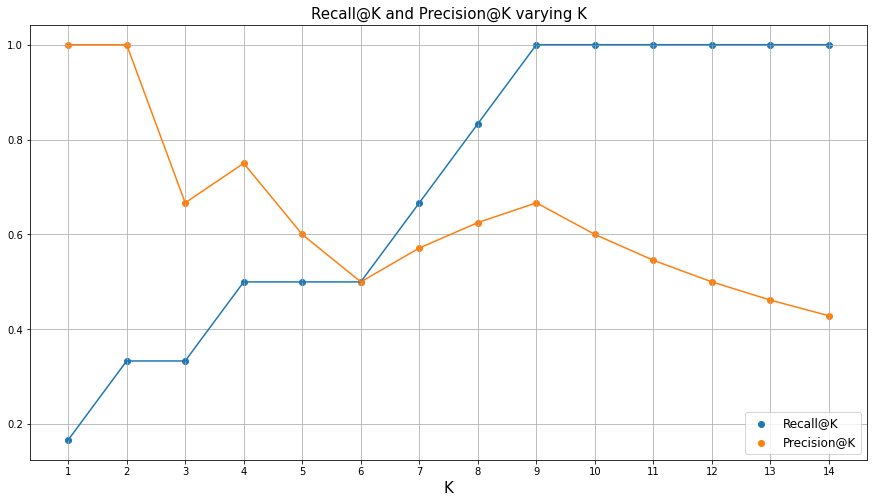

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.scatter(x = range(1, 15), y = list(recall.values()), label = "Recall@K")
plt.scatter(x = range(1, 15), y = list(precision.values()), label = "Precision@K")
plt.plot(range(1, 15), list(recall.values()))
plt.plot(range(1, 15), list(precision.values()))
plt.legend(fontsize = 12)
plt.title("Recall@K and Precision@K varying K", size = 15)
plt.xlabel("K", size = 15)
plt.xticks(range(1, 15))
plt.grid()
plt.show()

We can notice the breakeven point of precision-recall to be at K equal to 6.

## *RETRIEVER WRAPPER*

In this section we are going to create a single wrapper class `Retriever` that can retrieve documents given a query given a query and specifying a technique. It has the advantage to store the tokenized corpus and the dictionary of the occurrencies of tokens for each document, namely `Retriever.nd`. 

Which technique is currently in use is stored as a string into the attribute `Retriever.model`. To change the model in use, it is necessary to run the methos `Retriever.switch_to(model_name)` and the `model_name` should be one between: 

`'TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp'`. 

It will recumpute the idfs and store them in `Retriever.idf`.


#### Class definition

In [ ]:
import math
import numpy as np
from multiprocessing import Pool, cpu_count
from time import time
import warnings

class Retriever:
    def __init__(self, corpus = [], tokenizer=None, model=None, k1=1.5, b=0.75, epsilon=0.25, delta = 0.5):
        
        self.corpus = []              # corpus
        self.corpus_size = 0          # size of the corpus
        self.voc = []                 # vocabulary 
        self.voc_size = 0             # size of the vocabulary
        self.doc_len = []             # length of the documents 
        self.avgdl = 0                # average length of the documents 
        self.doc_freqs = []           # frequencies of word for every doc
        self.idf = {}                 # idf
        self.tokenizer = tokenizer    # tokenizer
        self.nd = {}                  # word -> number of documents with word
        self.model = model            # model to compute scores

        # Algotihm specific parameters
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        self.delta = delta

        if len(corpus) > 0:
          if tokenizer:
              print("Tokenizing the corpus ...")
              x = time()
              self.corpus = self._tokenize_corpus(corpus)
              x = time() - x
              print(f"Done! Time Elapsed: {x}")
          else: 
            self.corpus = corpus

          print("Computing tfs and creating the vocabulary ...")
          x = time()
          self._initialize()
          x = time() - x  
          print(f"Done! Time Elapsed: {x}")
        
        else:
          warnings.warn("corpus not provided, remember to insert it before computing the scores!") 

        if model: 
            if model not in ['TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp']:
                raise Exception(f"'{model}'' is not a valid model name. Pass one of the following names throught the Retriever.switch_to(model) method: \n'TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp ")
            
            else:
              if model != 'BM25Adpt' and len(self.corpus) > 0:
          
                print("Computing idfs ...")
                x = time()
                self._calc_idf()
                x = time() - x    
                print(f"Done! Time Elapsed: {x}")

        else:
            warnings.warn("model type not specified, remember to specify it before computing the scores!")


    def _initialize(self):
        nd = {}      # word -> number of documents with word
        num_doc = 0  # total length of the corpus in words
        self.corpus_size = 0
        self.doc_freqs = []
        self.doc_len = []
        for document in self.corpus:
            self.doc_len.append(len(document))
            num_doc += len(document)

            frequencies = {}
            for word in document:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1
            self.doc_freqs.append(frequencies)

            for word, freq in frequencies.items():
                try:
                    nd[word]+=1
                except KeyError:
                    nd[word] = 1

            self.corpus_size += 1

        self.voc = list(nd.keys())
        self.voc_size = len(self.voc)
        self.avgdl = num_doc / self.corpus_size
        self.nd = nd

    def switch_to(self, model):
      if model not in ['TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp']:
          raise Exception(f"'{model}'' is not a valid model name. Pass one of the following names throught the Retriever.switch_to(model) method: \n'TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp ")
      else:
          self.model = model
          if model != 'BM25Adpt':
            
            self.idf = {}
            print("Recomputing idfs ...")
            x = time()
            self._calc_idf()
            x = time() - x    
            print(f"Done! Time Elapsed: {x}")

        
    def _tokenize_corpus(self, corpus):  
        pool = Pool(cpu_count())    # Parallelize tokenization between cpus
        tokenized_corpus = pool.map(self.tokenizer, corpus)
        return tokenized_corpus

    def _calc_idf(self):
        
        if self.model in ["TFIDF", "BM25ATIRE"]:
          for word, freq in self.nd.items():              
              idf = math.log(self.corpus_size) - math.log(freq)
              self.idf[word] = idf

        elif self.model == "BM25Okapi":
          idf_sum = 0

          negative_idfs = []
          for word, freq in self.nd.items():
              idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
              self.idf[word] = idf
              idf_sum += idf
              if idf < 0:
                  negative_idfs.append(word)
          self.average_idf = idf_sum / len(self.idf)

          eps = self.epsilon * self.average_idf
          for word in negative_idfs:
              self.idf[word] = eps

        elif self.model == "BM25Lucene": 
          for word, freq in self.nd.items():
              idf = math.log(1 + (self.corpus_size - freq + 0.5)/(freq + 0.5))
              self.idf[word] = idf

        elif self.model == "BM25L":
          for word, freq in self.nd.items():
              idf = math.log(self.corpus_size + 1) - math.log(freq + 0.5)
              self.idf[word] = idf

        elif self.model in ["BM25Plus", "TFIDFldp"]:
          for word, freq in self.nd.items():
              idf = math.log((self.corpus_size + 1) / freq)
              self.idf[word] = idf

        elif self.model == "BM25Adpt":
          self.idf = {}




    def _dfr(self, q, r):
      if r == 0:
        return self.corpus_size
      elif r == 1:
        return self.nd.get(q) or 0
      else: 
        return np.sum(self.ctd - r + 0.5 > 0)
    
    def _G(self, q, r):  
      return math.log(self._dfr(q, r+1) + 0.5, 2) - math.log(self._dfr(q, r) + 1, 2) - \
          math.log(((self.nd.get(q) or 0) / self.corpus_size) + 0.5, 2) + math.log(self.corpus_size + 1, 2)

    def _calc_k(self, q):

      # Computing information gains until G(q, r) > G(q, r+1)
      Gs = [self._G(q, 0), self._G(q, 1)]
      r=2
      while True:
        if self._G(q, r) > Gs[-1]:
          Gs.append(self._G(q, r))
          r+=1
        else:
          break  

      # If G(q, r) > G(q, r+1) happens for r = 1, the optimal value of k is undefined,
      # we set k = 0.001, as in Trotman et al.
      if len(Gs) == 2:
        return 0.001
      
      ks = np.arange(0.001, 2.5, 0.001)                # array of candidates k
      res_to_minimize = np.array([np.sum([
          (Gs[i] / Gs[1] - (k + 1) * i / (k + i))**2 
          for i in range(len(Gs))]
          ) for k in ks])

      return ks[np.argmin(res_to_minimize)]


    def get_scores(self, query):

        query = self.tokenizer(query)
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)

        if self.model == "TFIDF": 

          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              score += (self.idf.get(q) or 0) * (np.log(1 + q_freq))
          return score

        elif self.model == "BM25Okapi":

          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              score += (self.idf.get(q) or 0) * (q_freq /
                                                (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
          return score
        
        elif self.model == "BM25Lucene":

          score = np.zeros(self.corpus_size)
          doc_len = np.array(self.doc_len)
          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              score += (self.idf.get(q) or 0) * (q_freq * /
                                                (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
          return score


        elif self.model == "BM25ATIRE":

          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              score += (self.idf.get(q) or 0) * ((self.k1 + 1)* q_freq /
                                                  (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
          return score

        elif self.model == "BM25L":

          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
              score += (self.idf.get(q) or 0) * (self.k1 + 1) * (ctd + self.delta) / \
                      (self.k1 + ctd + self.delta)
          return score

        elif self.model == "BM25Plus":

          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              score += (self.idf.get(q) or 0) * (self.delta + (q_freq * (self.k1 + 1)) /
                                                (self.k1 * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
          return score

        elif self.model == "BM25Adpt":

          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              self.ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
              k = self._calc_k(q)
              score += (self._G(q, 1)) * (q_freq * (k + 1) /
                                                (k * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
          return score

        elif self.model == "TFIDFldp":

          for q in query:
              q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
              score += (self.idf.get(q) or 0) * (1 + np.log(1 + np.log(
                  q_freq / (1 - self.b + self.b * doc_len / self.avgdl) + self.delta
                  )))
              
          return score
          


    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

## *EVALUATION*


We are going to evaliate the models with different metrics (here with $k$ we mean the number of documents retrieved):
* **R-Precision**:  It is the precision  with $k$ fixed to the number of relevant documents
* **Mean Average Precision (MAP)**: It is the average of precisions for $k$ varying from 1 to the number of relevant documents. 
* **Recall@K**: It is the recall with various $k$, we have recorded it for $k \in [1, .., 15]$ 
* **Precision@K**: It is the precision with various $k$, we have recorded it for $k \in [1, .., 15]$

To run the evaluation on WikIR run the *WikIR* section, while to run the evaluation on 

### On WikIR

In [ ]:
docs = w_docs
queries = w_queries
qrels = w_qrels

In [ ]:
retriever = Retriever(tokenizer = tokenizer)

retriever.corpus = docs["cleaned_text"]
retriever._initialize()

<ipython-input-5-b32962637a26>:45: UserWarning: corpus not provided, remember to insert it before computing the scores!
  warnings.warn("corpus not provided, remember to insert it before computing the scores!")
<ipython-input-5-b32962637a26>:61: UserWarning: model type not specified, remember to specify it before computing the scores!
  warnings.warn("model type not specified, remember to specify it before computing the scores!")


In [ ]:
from tqdm import tqdm
import numpy as np

if not on_drive:

  models = ['TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp']
  results = {}

  for model in models:
      print(f"################### {model} ###################")
      retriever.switch_to(model)
        
      recall = {}
      precision = {}
      R_precision = []
      MAP = []
      for top_n in range(1, 15):
        recall[top_n] = []
        precision[top_n] = []

      print("EVALUATING ...")
      for i, row in tqdm(queries.iterrows(), total = len(queries)): ####

          query = row["text_left"] 
          q_id = row["id_left"]
          rel_docs_id = qrels[qrels["id_left"] == q_id]["id_right"] ####

          doc_scores = np.array(retriever.get_scores(query))

          # Computing R-precision
          n_rels = len(rel_docs_id) 
          ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
          ind = ind[np.argsort(doc_scores[ind])]
          ind = ind[::-1]
          pred_ids = docs.iloc[ind]["id_right"]
          R_precision.append(len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels)

          # Computing MAP
          n_rels = len(rel_docs_id)
          ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
          ind = ind[np.argsort(doc_scores[ind])]
          ind = ind[::-1]
          pred_ids = docs.iloc[ind]["id_right"]
          map = []
          for k in range(1, n_rels+1):
            map.append(
                len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
            )
          MAP.append(np.mean(map))

          # Computing Precision@K and Recall@K for K in 1..15
          for top_n in range(1, 15):

              ind = np.argpartition(doc_scores, -top_n)[-top_n:]
              ind = ind[np.argsort(doc_scores[ind])]
              ind = ind[::-1]

              pred_ids = docs.iloc[ind]["id_right"]

              recall[top_n].append(len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id))
              precision[top_n].append(len(set(pred_ids).intersection(set(rel_docs_id))) / top_n)

          
      R_precision = np.mean(R_precision)
      MAP = np.mean(MAP)
      recall_k = [np.mean(r) for r in recall.values()]
      precision_k = [np.mean(p) for p in precision.values()]

      res = {"R_precision": R_precision, 
            "MAP": MAP, 
            "Recall@K": recall_k,
            "Precision@K": precision_k}

      results[model] = res

################### TFIDF ###################
Recomputing idfs ...
Done! Time Elapsed: 1.1730942726135254
EVALUATING ...


100%|██████████| 1644/1644 [15:22<00:00,  1.78it/s]


################### BM25Okapi ###################
Recomputing idfs ...
Done! Time Elapsed: 0.9946706295013428
EVALUATING ...


100%|██████████| 1644/1644 [15:16<00:00,  1.79it/s]


################### BM25Lucene ###################
Recomputing idfs ...
Done! Time Elapsed: 0.7325081825256348
EVALUATING ...


100%|██████████| 1644/1644 [16:14<00:00,  1.69it/s]


################### BM25ATIRE ###################
Recomputing idfs ...
Done! Time Elapsed: 0.8465702533721924
EVALUATING ...


100%|██████████| 1644/1644 [15:22<00:00,  1.78it/s]


################### BM25Plus ###################
Recomputing idfs ...
Done! Time Elapsed: 0.5691235065460205
EVALUATING ...


100%|██████████| 1644/1644 [15:00<00:00,  1.82it/s]


################### BM25L ###################
Recomputing idfs ...
Done! Time Elapsed: 0.8525419235229492
EVALUATING ...


100%|██████████| 1644/1644 [15:05<00:00,  1.82it/s]


################### BM25Adpt ###################
EVALUATING ...


100%|██████████| 1644/1644 [18:30<00:00,  1.48it/s]


################### TFIDFldp ###################
Recomputing idfs ...
Done! Time Elapsed: 0.57415771484375
EVALUATING ...


100%|██████████| 1644/1644 [15:24<00:00,  1.78it/s]


Saving the results in Drive

In [ ]:
results = pd.DataFrame(results).transpose()

if not on_drive: 
  results_path = "/content/gdrive/MyDrive/WikIR_results.csv"
  results.to_csv(results_path)

Download the results

In [ ]:
if on_drive: 
  results_path = "/content/gdrive/MyDrive/WikIR_results.csv"
  results = pd.read_csv(results_path, index_col = 0)

  def str_to_list(s):
    s = s.replace("[", "").replace("]", "").replace(",", "")
    l = [float(x) for x in s.split()]
    return l

  results["Recall@K"] = results["Recall@K"].map(str_to_list)
  results["Precision@K"] = results["Precision@K"].map(str_to_list)

Let's see R-precision Mean Average Precision

In [ ]:
display(results[["R_precision", "MAP"]])

,R_precision,MAP
TFIDF,0.203729,0.293192
BM25Okapi,0.217183,0.309620
BM25Lucene,0.217649,0.309646
BM25ATIRE,0.217693,0.309652
BM25Plus,0.217693,0.309652
BM25L,0.216105,0.308436
BM25Adpt,0.214812,0.307154
TFIDFldp,0.217285,0.309817


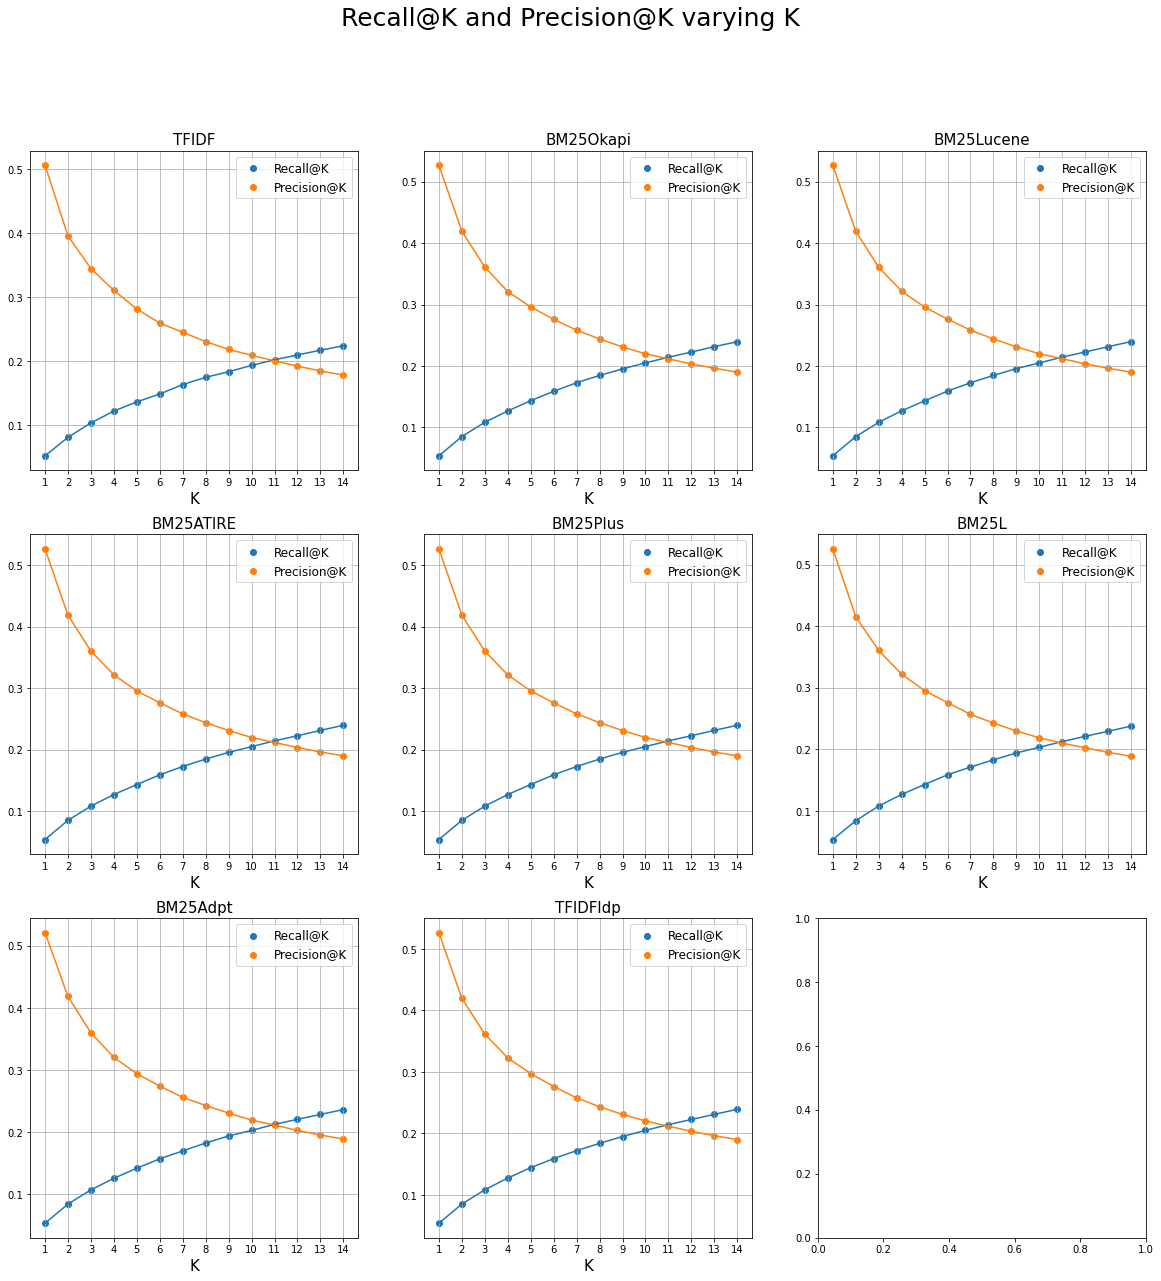

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize = (20, 20))

fig.suptitle("Recall@K and Precision@K varying K", size = 25)

for i in range(8):
  a = i // 3
  b = i % 3

  row = results.iloc[i]

  model_name = row.name
  recall = row["Recall@K"]
  precision = row["Precision@K"]

  plt.figure(figsize = (15, 8))
  axs[a, b].scatter(x = range(1, 15), y = list(recall), label = "Recall@K")
  axs[a, b].scatter(x = range(1, 15), y = list(precision), label = "Precision@K")
  axs[a, b].plot(range(1, 15), list(recall))
  axs[a, b].plot(range(1, 15), list(precision))
  axs[a, b].legend(fontsize = 12)
  axs[a, b].set_title(model_name, size = 15)
  axs[a, b].set_xlabel("K", size = 15)
  axs[a, b].set_xticks(range(1, 15))
  axs[a, b].grid()

fig.show()

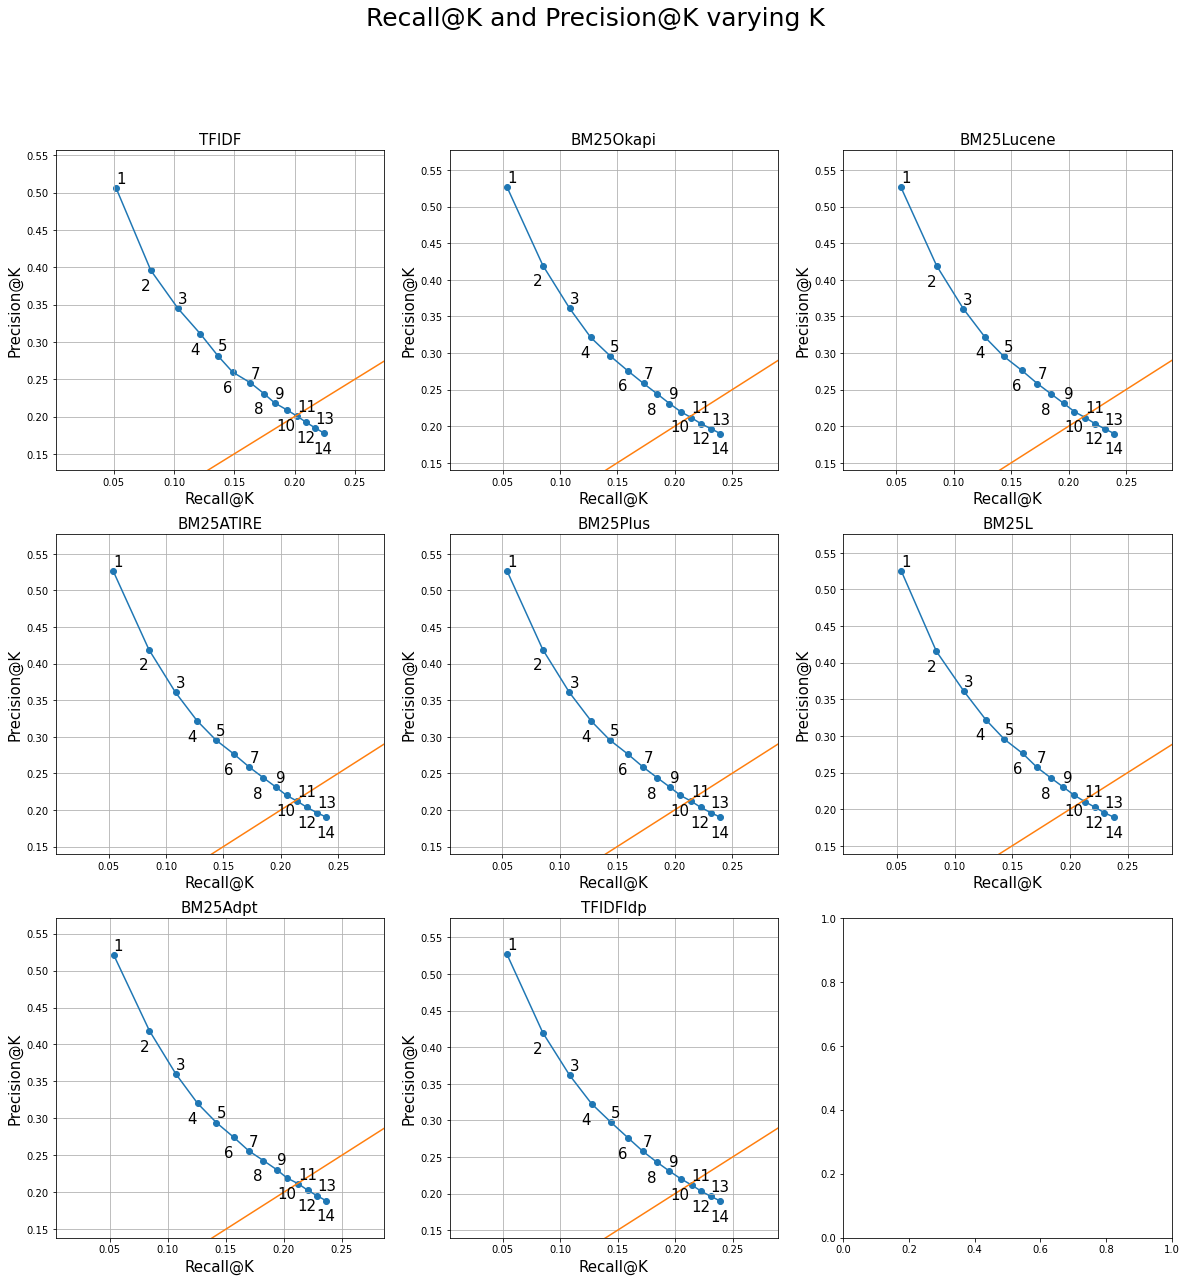

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(3, 3, figsize = (20, 20))

fig.suptitle("Recall@K and Precision@K varying K", size = 25)

for i in range(8):
  a = i // 3
  b = i % 3

  row = results.iloc[i]

  model_name = row.name
  recall = row["Recall@K"]
  precision = row["Precision@K"]

  plt.figure(figsize = (15, 8))
  axs[a, b].scatter(x = list(recall), y = list(precision))
  axs[a, b].plot(list(recall), list(precision))
  for k in range(len(recall)):
    if k%2==0:
      xytext = (0,5)
    else:
      xytext = (-10,-20)
    axs[a, b].annotate(
        k+1,
        (recall[k], precision[k]), 
        size = 15,
        textcoords="offset points", 
        xytext = xytext
    )
  axs[a, b].plot([0,1], [0,1])
  axs[a, b].set_xlabel("Recall@K", size = 15)
  axs[a, b].set_ylabel("Precision@K", size = 15)
  axs[a, b].set_xlim(np.min(recall)-0.05, np.max(recall)+0.05)
  axs[a, b].set_ylim(np.min(precision)-0.05, np.max(precision)+0.05)
  axs[a, b].set_title(model_name, size = 15)
  axs[a, b].grid()



fig.show()

We can see that for every model, the Precision-Recall Breakeven point is at K equal to 11. 

### On FIQA - 2018

In [ ]:
docs = f_docs
queries = f_queries
qrels = f_qrels

In [ ]:
retriever = Retriever(tokenizer = tokenizer)

retriever.corpus = docs["cleaned_text"]
retriever._initialize()

<ipython-input-21-b32962637a26>:45: UserWarning: corpus not provided, remember to insert it before computing the scores!
  warnings.warn("corpus not provided, remember to insert it before computing the scores!")
<ipython-input-21-b32962637a26>:61: UserWarning: model type not specified, remember to specify it before computing the scores!
  warnings.warn("model type not specified, remember to specify it before computing the scores!")


In [ ]:
from tqdm import tqdm
import numpy as np

if not on_drive: 

  models = ['TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp']
  results = {}

  for model in models:
      print(f"################### {model} ###################")
      retriever.switch_to(model)
        
      recall = {}
      precision = {}
      R_precision = []
      MAP = []
      for top_n in range(1, 15):
        recall[top_n] = []
        precision[top_n] = []

      print("EVALUATING ...")
      for i, row in tqdm(queries.iterrows(), total = len(queries)): ####

          query = row["text"] 
          q_id = row["_id"]
          rel_docs_id = qrels[qrels["query-id"] == q_id]["corpus-id"] ####

          doc_scores = np.array(retriever.get_scores(query))

          # Computing R-precision
          n_rels = len(rel_docs_id) 
          ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
          ind = ind[np.argsort(doc_scores[ind])]
          ind = ind[::-1]
          pred_ids = docs.iloc[ind]["_id"]
          R_precision.append(len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels)

          # Computing MAP
          n_rels = len(rel_docs_id)
          ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
          ind = ind[np.argsort(doc_scores[ind])]
          ind = ind[::-1]
          pred_ids = docs.iloc[ind]["_id"]
          map = []
          for k in range(1, n_rels+1):
            map.append(
                len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
            )
          MAP.append(np.mean(map))

          # Computing Precision@K and Recall@K for K in 1..15
          for top_n in range(1, 15):

              ind = np.argpartition(doc_scores, -top_n)[-top_n:]
              ind = ind[np.argsort(doc_scores[ind])]
              ind = ind[::-1]

              pred_ids = docs.iloc[ind]["_id"]

              recall[top_n].append(len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id))
              precision[top_n].append(len(set(pred_ids).intersection(set(rel_docs_id))) / top_n)

          
      R_precision = np.mean(R_precision)
      MAP = np.mean(MAP)
      recall_k = [np.mean(r) for r in recall.values()]
      precision_k = [np.mean(p) for p in precision.values()]

      res = {"R_precision": R_precision, 
            "MAP": MAP, 
            "Recall@K": recall_k,
            "Precision@K": precision_k}

      results[model] = res

################### TFIDF ###################
Recomputing idfs ...
Done! Time Elapsed: 0.14439678192138672
EVALUATING ...


100%|██████████| 6648/6648 [31:18<00:00,  3.54it/s]


################### BM25Okapi ###################
Recomputing idfs ...
Done! Time Elapsed: 0.1884019374847412
EVALUATING ...


100%|██████████| 6648/6648 [23:45<00:00,  4.66it/s]


################### BM25Lucene ###################
Recomputing idfs ...
Done! Time Elapsed: 0.14255881309509277
EVALUATING ...


100%|██████████| 6648/6648 [22:58<00:00,  4.82it/s]


################### BM25ATIRE ###################
Recomputing idfs ...
Done! Time Elapsed: 0.08015298843383789
EVALUATING ...


100%|██████████| 6648/6648 [24:57<00:00,  4.44it/s]


################### BM25Plus ###################
Recomputing idfs ...
Done! Time Elapsed: 0.07321667671203613
EVALUATING ...


100%|██████████| 6648/6648 [22:27<00:00,  4.93it/s]


################### BM25L ###################
Recomputing idfs ...
Done! Time Elapsed: 0.08598923683166504
EVALUATING ...


100%|██████████| 6648/6648 [22:03<00:00,  5.02it/s]


################### BM25Adpt ###################
EVALUATING ...


100%|██████████| 6648/6648 [28:44<00:00,  3.86it/s]


################### TFIDFldp ###################
Recomputing idfs ...
Done! Time Elapsed: 0.06647372245788574
EVALUATING ...


100%|██████████| 6648/6648 [22:47<00:00,  4.86it/s]


Saving the results in Drive

In [ ]:
results = pd.DataFrame(results).transpose()

if not on_drive:
  results_path = "/content/gdrive/MyDrive/fiqa_results.csv"
  results.to_csv(results_path)

Download the results

In [ ]:
if on_drive:   
  results_path = "/content/gdrive/MyDrive/fiqa_results.csv"
  results = pd.read_csv(results_path, index_col = 0)

  def str_to_list(s):
    s = s.replace("[", "").replace("]", "").replace(",", "")
    l = [float(x) for x in s.split()]
    return l

  results["Recall@K"] = results["Recall@K"].map(str_to_list)
  results["Precision@K"] = results["Precision@K"].map(str_to_list)

Let's see R-precision Mean Average Precision

In [ ]:
display(results[["R_precision", "MAP"]])

,R_precision,MAP
TFIDF,0.085962,0.096491
BM25Okapi,0.155348,0.179869
BM25Lucene,0.156286,0.180682
BM25ATIRE,0.156511,0.180970
BM25Plus,0.156511,0.180970
BM25L,0.150471,0.174680
BM25Adpt,0.110888,0.128257
TFIDFldp,0.162792,0.187771


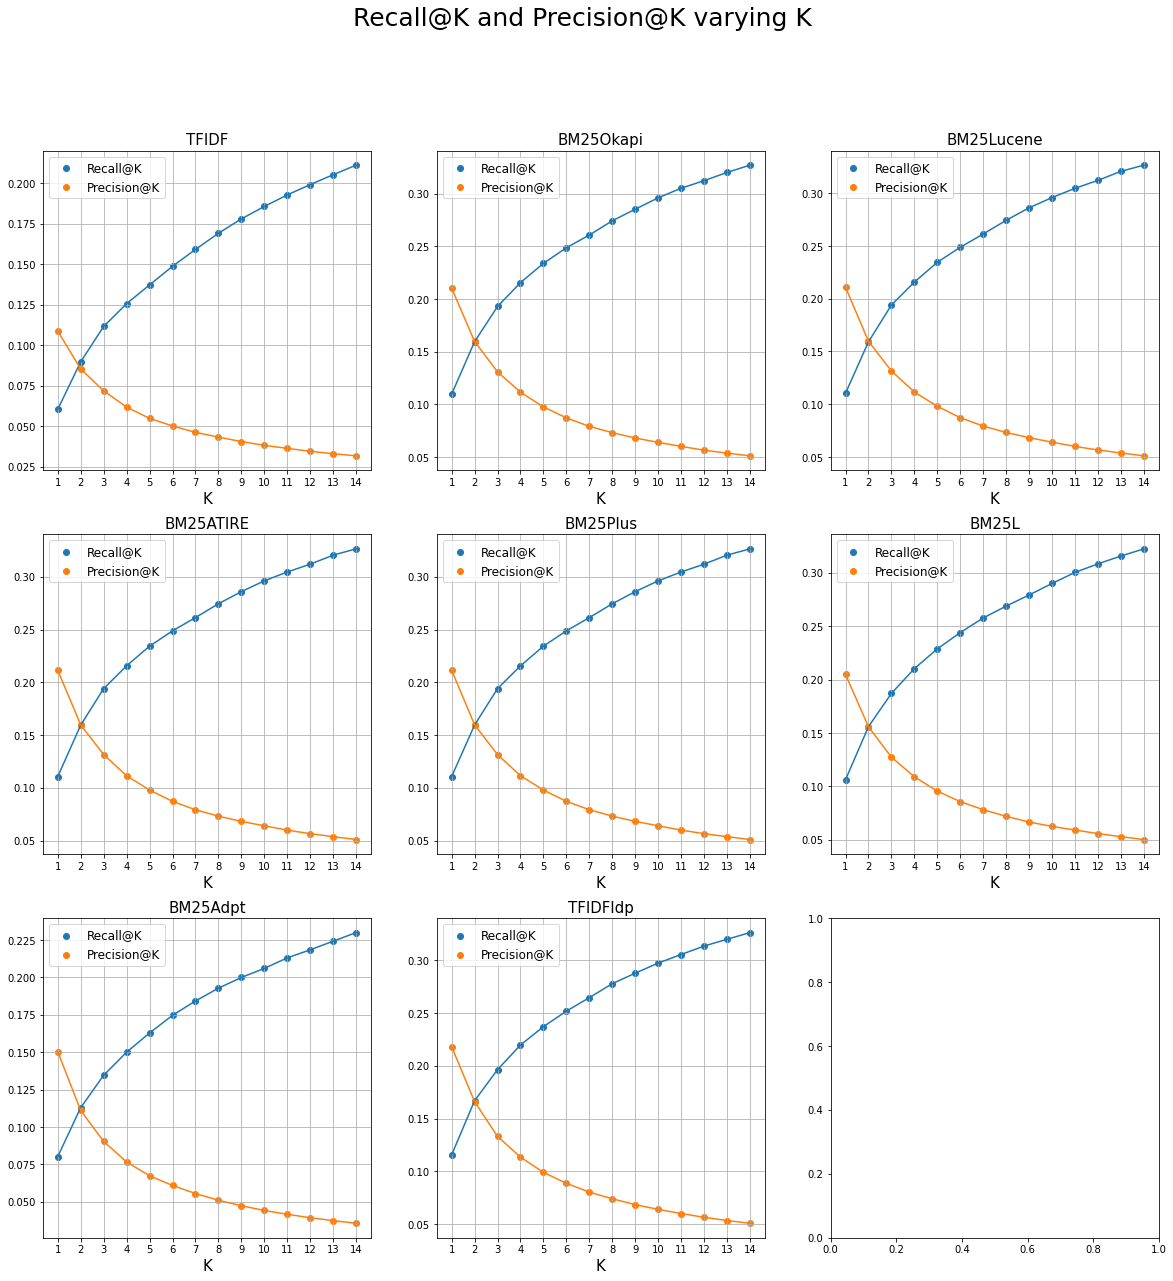

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize = (20, 20))

fig.suptitle("Recall@K and Precision@K varying K", size = 25)

for i in range(8):
  a = i // 3
  b = i % 3

  row = results.iloc[i]

  model_name = row.name
  recall = row["Recall@K"]
  precision = row["Precision@K"]

  plt.figure(figsize = (15, 8))
  axs[a, b].scatter(x = range(1, 15), y = list(recall), label = "Recall@K")
  axs[a, b].scatter(x = range(1, 15), y = list(precision), label = "Precision@K")
  axs[a, b].plot(range(1, 15), list(recall))
  axs[a, b].plot(range(1, 15), list(precision))
  axs[a, b].legend(fontsize = 12)
  axs[a, b].set_title(model_name, size = 15)
  axs[a, b].set_xlabel("K", size = 15)
  axs[a, b].set_xticks(range(1, 15))
  axs[a, b].grid()

fig.show()

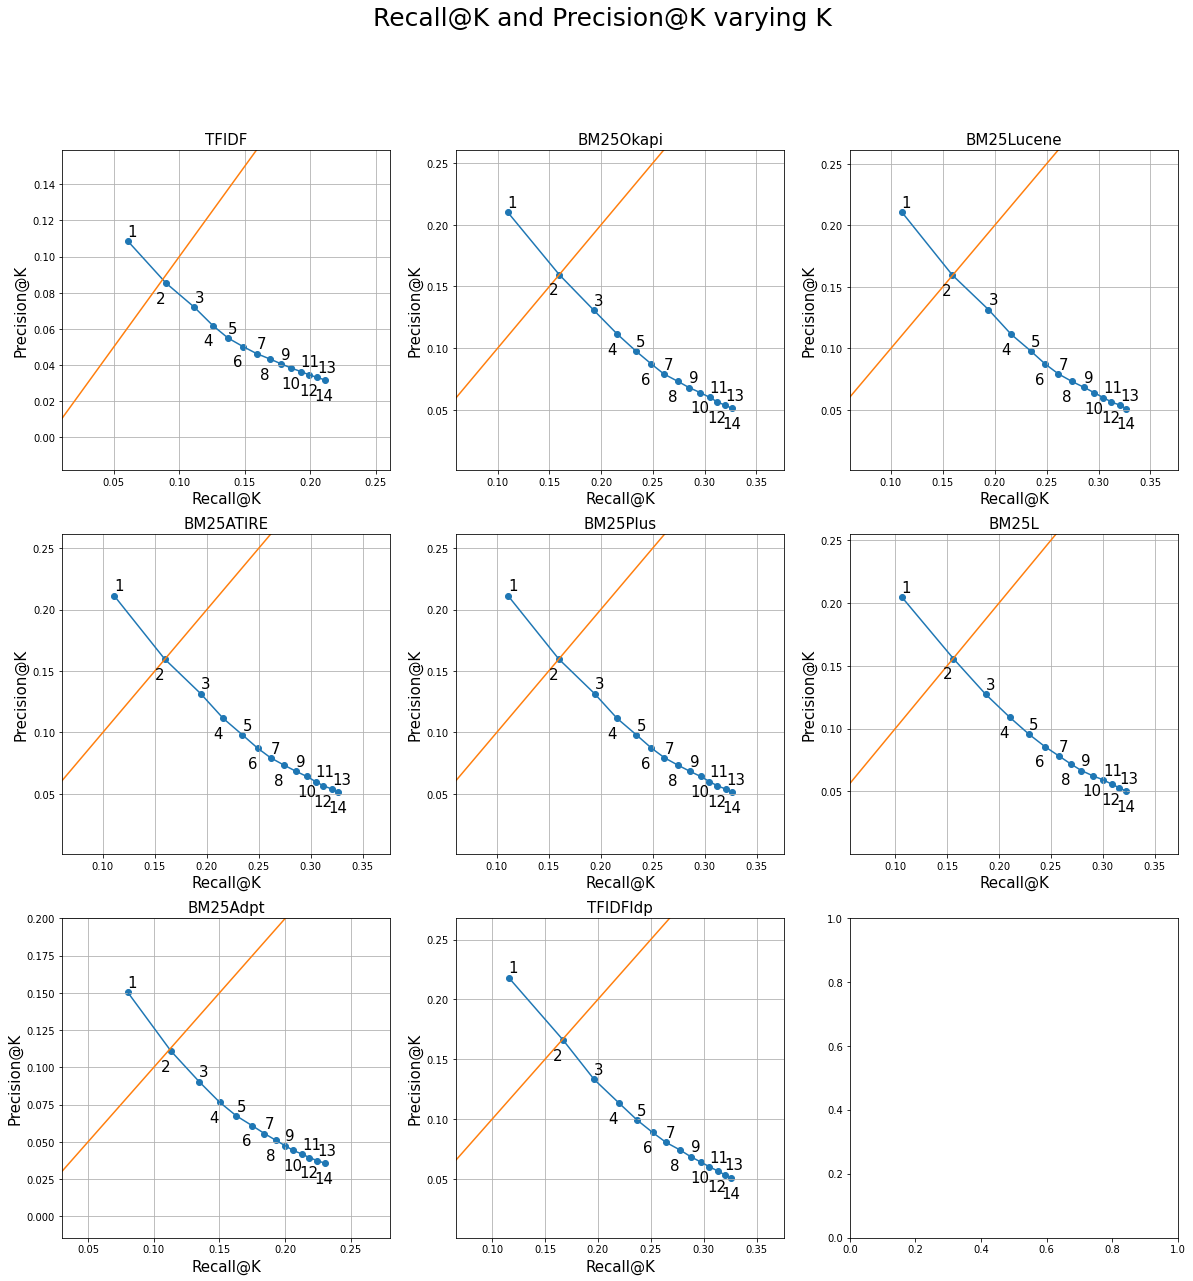

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(3, 3, figsize = (20, 20))

fig.suptitle("Recall@K and Precision@K varying K", size = 25)

for i in range(8):
  a = i // 3
  b = i % 3

  row = results.iloc[i]

  model_name = row.name
  recall = row["Recall@K"]
  precision = row["Precision@K"]

  plt.figure(figsize = (15, 8))
  axs[a, b].scatter(x = list(recall), y = list(precision))
  axs[a, b].plot(list(recall), list(precision))
  for k in range(len(recall)):
    if k%2==0:
      xytext = (0,5)
    else:
      xytext = (-10,-20)
    axs[a, b].annotate(
        k+1,
        (recall[k], precision[k]), 
        size = 15,
        textcoords="offset points", 
        xytext = xytext
    )
  axs[a, b].plot([0,1], [0,1])
  axs[a, b].set_xlabel("Recall@K", size = 15)
  axs[a, b].set_ylabel("Precision@K", size = 15)
  axs[a, b].set_xlim(np.min(recall)-0.05, np.max(recall)+0.05)
  axs[a, b].set_ylim(np.min(precision)-0.05, np.max(precision)+0.05)
  axs[a, b].set_title(model_name, size = 15)
  axs[a, b].grid()



fig.show()

We can see that for every model, the Precision-Recall Breakeven point is at K equal to 2. 

### On Touché - 2020

In [ ]:
docs = t_docs
queries = t_queries
qrels = t_qrels

In [ ]:
retriever = Retriever(tokenizer = tokenizer)

retriever.corpus = docs["cleaned_text"]
retriever._initialize()

<ipython-input-148-e2732b0ffc4d>:45: UserWarning: corpus not provided, remember to insert it before computing the scores!
  warnings.warn("corpus not provided, remember to insert it before computing the scores!")
<ipython-input-148-e2732b0ffc4d>:61: UserWarning: model type not specified, remember to specify it before computing the scores!
  warnings.warn("model type not specified, remember to specify it before computing the scores!")


In [ ]:
from tqdm import tqdm
import numpy as np

if not on_drive:

  models = ['TFIDF', 'BM25Okapi', 'BM25Lucene', 'BM25ATIRE', 'BM25Plus', 'BM25L', 'BM25Adpt', 'TFIDFldp']
  results = {}

  for model in models:
      print(f"################### {model} ###################")
      retriever.switch_to(model)
        
      recall = {}
      precision = {}
      R_precision = []
      MAP = []
      for top_n in range(1, 25):
        recall[top_n] = []
        precision[top_n] = []

      print("EVALUATING ...")
      for i, row in tqdm(queries.iterrows(), total = len(queries)): ####

          query = row["text"] 
          q_id = row["_id"]
          rel_docs_id = qrels[qrels["query-id"] == q_id]["corpus-id"] ####

          doc_scores = np.array(retriever.get_scores(query))

          # Computing R-precision
          n_rels = len(rel_docs_id) 
          ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
          ind = ind[np.argsort(doc_scores[ind])]
          ind = ind[::-1]
          pred_ids = docs.iloc[ind]["_id"]
          R_precision.append(len(set(pred_ids).intersection(set(rel_docs_id))) / n_rels)

          # Computing MAP
          n_rels = len(rel_docs_id)
          ind = np.argpartition(doc_scores, -n_rels)[-n_rels:]
          ind = ind[np.argsort(doc_scores[ind])]
          ind = ind[::-1]
          pred_ids = docs.iloc[ind]["_id"]
          map = []
          for k in range(1, n_rels+1):
            map.append(
                len(set(pred_ids[:k]).intersection(set(rel_docs_id))) / k
            )
          MAP.append(np.mean(map))

          # Computing Precision@K and Recall@K for K in 1..15
          for top_n in range(1, 25):

              ind = np.argpartition(doc_scores, -top_n)[-top_n:]
              ind = ind[np.argsort(doc_scores[ind])]
              ind = ind[::-1]

              pred_ids = docs.iloc[ind]["_id"]

              recall[top_n].append(len(set(pred_ids).intersection(set(rel_docs_id))) / len(rel_docs_id))
              precision[top_n].append(len(set(pred_ids).intersection(set(rel_docs_id))) / top_n)

          
      R_precision = np.mean(R_precision)
      MAP = np.mean(MAP)
      recall_k = [np.mean(r) for r in recall.values()]
      precision_k = [np.mean(p) for p in precision.values()]

      res = {"R_precision": R_precision, 
            "MAP": MAP, 
            "Recall@K": recall_k,
            "Precision@K": precision_k}

      results[model] = res

################### TFIDF ###################
Recomputing idfs ...
Done! Time Elapsed: 1.395951509475708
EVALUATING ...


100%|██████████| 49/49 [01:04<00:00,  1.32s/it]


################### BM25Okapi ###################
Recomputing idfs ...
Done! Time Elapsed: 1.0204575061798096
EVALUATING ...


100%|██████████| 49/49 [00:41<00:00,  1.17it/s]


################### BM25Lucene ###################
Recomputing idfs ...
Done! Time Elapsed: 0.7749443054199219
EVALUATING ...


100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


################### BM25ATIRE ###################
Recomputing idfs ...
Done! Time Elapsed: 1.2813780307769775
EVALUATING ...


100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


################### BM25Plus ###################
Recomputing idfs ...
Done! Time Elapsed: 0.730400562286377
EVALUATING ...


100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


################### BM25L ###################
Recomputing idfs ...
Done! Time Elapsed: 0.923288106918335
EVALUATING ...


100%|██████████| 49/49 [00:42<00:00,  1.14it/s]


################### BM25Adpt ###################
EVALUATING ...


100%|██████████| 49/49 [00:56<00:00,  1.15s/it]


################### TFIDFldp ###################
Recomputing idfs ...
Done! Time Elapsed: 0.7484488487243652
EVALUATING ...


100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Saving the results in Drive

In [ ]:
results = pd.DataFrame(results).transpose()

if not on_drive:
  results_path = "/content/gdrive/MyDrive/touche_results.csv"
  results.to_csv(results_path)

Download the results

In [ ]:
if on_drive:
  results_path = "/content/gdrive/MyDrive/touche_results.csv"
  results = pd.read_csv(results_path, index_col = 0)

  def str_to_list(s):
    s = s.replace("[", "").replace("]", "").replace(",", "")
    l = [float(x) for x in s.split()]
    return l

  results["Recall@K"] = results["Recall@K"].map(str_to_list)
  results["Precision@K"] = results["Precision@K"].map(str_to_list)

Let's see R-precision Mean Average Precision

In [ ]:
display(results[["R_precision", "MAP"]])

,R_precision,MAP
TFIDF,0.305540,0.464278
BM25Okapi,0.261010,0.329824
BM25Lucene,0.256483,0.329079
BM25ATIRE,0.256483,0.329079
BM25Plus,0.256483,0.329079
BM25L,0.252795,0.330276
BM25Adpt,0.229180,0.312880
TFIDFldp,0.273467,0.346634


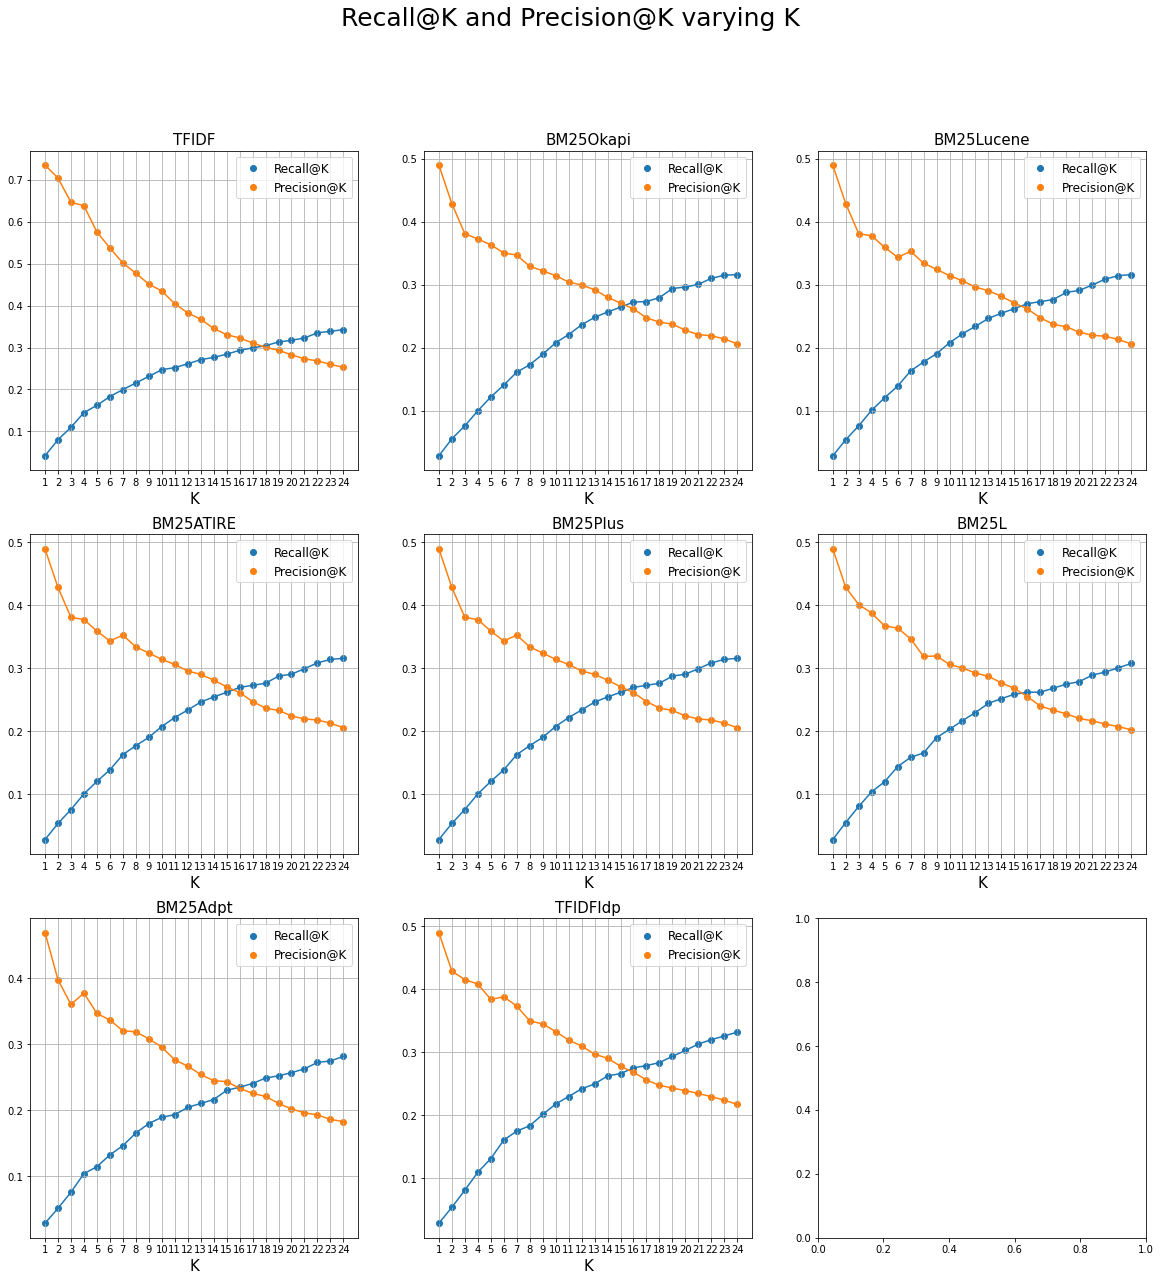

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize = (20, 20))

fig.suptitle("Recall@K and Precision@K varying K", size = 25)

for i in range(8):
  a = i // 3
  b = i % 3

  row = results.iloc[i]

  model_name = row.name
  recall = row["Recall@K"]
  precision = row["Precision@K"]

  plt.figure(figsize = (15, 8))
  axs[a, b].scatter(x = range(1, 25), y = list(recall), label = "Recall@K")
  axs[a, b].scatter(x = range(1, 25), y = list(precision), label = "Precision@K")
  axs[a, b].plot(range(1, 25), list(recall))
  axs[a, b].plot(range(1, 25), list(precision))
  axs[a, b].legend(fontsize = 12)
  axs[a, b].set_title(model_name, size = 15)
  axs[a, b].set_xlabel("K", size = 15)
  axs[a, b].set_xticks(range(1, 25))
  axs[a, b].grid()

fig.show()

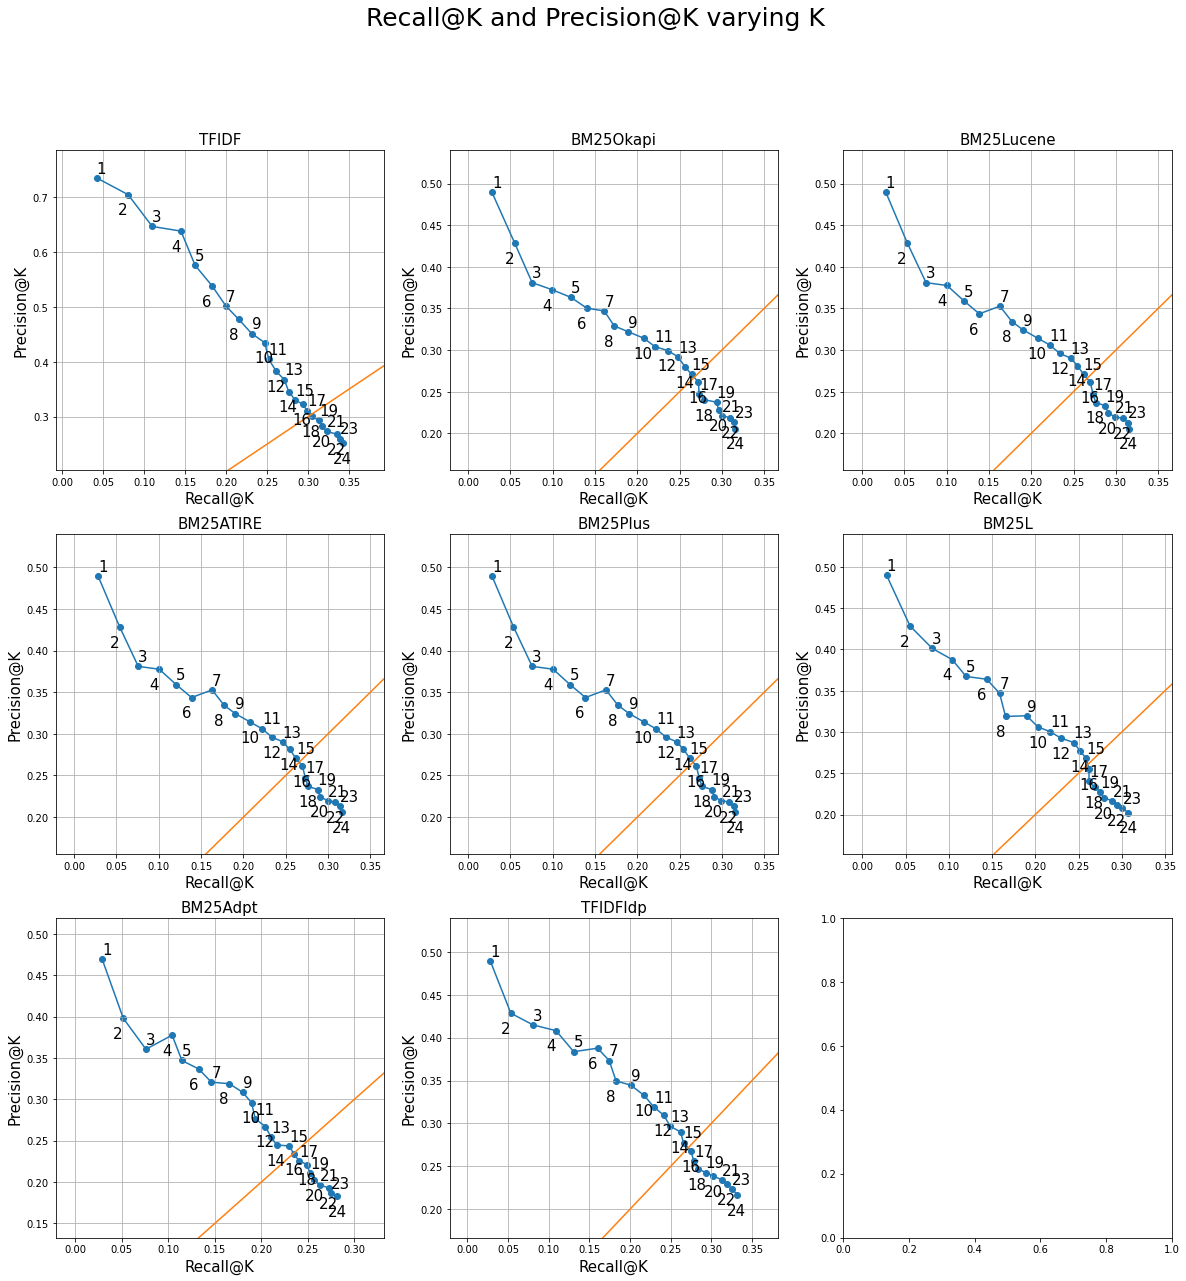

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(3, 3, figsize = (20, 20))

fig.suptitle("Recall@K and Precision@K varying K", size = 25)

for i in range(8):
  a = i // 3
  b = i % 3

  row = results.iloc[i]

  model_name = row.name
  recall = row["Recall@K"]
  precision = row["Precision@K"]

  plt.figure(figsize = (15, 8))
  axs[a, b].scatter(x = list(recall), y = list(precision))
  axs[a, b].plot(list(recall), list(precision))
  for k in range(len(recall)):
    if k%2==0:
      xytext = (0,5)
    else:
      xytext = (-10,-20)
    axs[a, b].annotate(
        k+1,
        (recall[k], precision[k]), 
        size = 15,
        textcoords="offset points", 
        xytext = xytext
    )
  axs[a, b].plot([0,1], [0,1])
  axs[a, b].set_xlabel("Recall@K", size = 15)
  axs[a, b].set_ylabel("Precision@K", size = 15)
  axs[a, b].set_xlim(np.min(recall)-0.05, np.max(recall)+0.05)
  axs[a, b].set_ylim(np.min(precision)-0.05, np.max(precision)+0.05)
  axs[a, b].set_title(model_name, size = 15)
  axs[a, b].grid()



fig.show()

We can see that for every model, the Precision-Recall Breakeven point is between 15 and 16. 

# References
<a name="ref"></a>

[1] Frej J., Schwab D., Chevallet J.P.,  WIKIR: A Python toolkit for building a large-scale Wikipedia-based English Information Retrieval Dataset, LREC 2020

[2] Trotman A., Puurula A., Burgess B., Improvements to BM25 and Language Models Examined, ADCS 2014

[3] Kamphuis C., P. de Vries A., Boytsov L., Lin J., Which BM25 Do You Mean? A Large-Scale Reproducibility Study of Scoring Variants, Advances iin Information Retrieval 2020, p. 28-34 

[4] Robertson S., Walker S., Jones S., Hancock-Beaulieu M. M., Gatford M., OKapi at TREC-3, TREC-3 1995

[5] Trotman A., Jia X.F., Crane M., Towards an efficient and effective search engine, SIGIR 2012

[6] Lv Y., Zhai C., When documents are very long, BM25 fails! SIGIR, 2011

[7] Lv Y., Zhai C., Lower-bounding term frequency normalization, CIKM 2011

[8] Lv Y., C. Zhai, Adaptive term frequency normalization for
BM25, CIKM 2011, p. 1985-1988

[9] Rousseau F., M. Vazirgiannis, Composition of TF normalizations: new insights on scoring functions for ad hoc IR, SIGIR 2013

[10] Thakur N., Reimers N., Ruckle A., Srivastava A., Gurevych I., BEIR: A Heterogenous Benchmark for Zero-shot Evaluation of Information Retrieval Models, NeurIPS 2021
